# Predictive Analysis of Sea Surface Currents Velocity 'v' (North-South)

This Notebook is an analysis and prediction of sea surface currents (SSC) velocity using an LSTM Model. The primary focus is on processing, visualizing, and predicting based on historical sea surface current data. This pipeline aims to provide a comprehensive workflow from data processing to real-life future predictions, facilitating deeper insights into sea surface currents and their potential impacts.

## Overview
- **Data Preparation**: Loading and cleaning of time-series data from NetCDF files to create a structured dataset suitable for analysis.
- **Geospatial Visualization**: Mapping sea surface current data and identify areas of interest.
- **Data Filtering**: Narrowing down the dataset to focus on specific geographic regions and time frames for detailed analysis.
- **Predictive Modeling**: Developing LSTM models to forecast future sea surface current velocities based on historical data.
- **Evaluation**: Comparing predicted values against actual data to assess the accuracy and effectiveness of the models.
- **Output**: Aggregating all predictions and converting them into a format suitable for further analysis or integration into a Lagrangian Model.

### Import Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.models import load_model

### Suppress Future Warnings

In [2]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the Data

Load and open the sea surface current dataset for subsequent analysis and modeling. This file has hourly data from 1st January 2020 till 1st August 2023

In [3]:
# Load the dataset
netcdf_file_path = "Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

### Data Preparation 

1. **Conversion and Index Resetting**: The dataset is converted to a Pandas DataFrame and the index is reset.
2. **Column Removal**: Unnecessary columns ('stdu', 'stdv', 'cov', 'velo', 'head') that are not needed are removed.
3. **NaN Value Removal**: Rows containing NaN values in the 'u' and 'v' columns are removed.
4. **Datetime Conversion**: The 'time' column is converted to a datetime format.
5. **Display**: Finally, the cleaned DataFrame is displayed to verify the successful preprocessing steps.

In [4]:
# Convert the dataset to a pandas DataFrame and reset the index 
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns to ensure data integrity for analysis
df.dropna(subset=['u', 'v'],inplace=True)

# Convert the 'time' column to datetime format for time series analysis
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Display the DataFrame
df

time        lat      lon         u   
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436  \
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6097  0.225030   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6503  0.219380   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6908  0.192193   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  15.0965 -0.088404   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0419 -0.179297   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0824 -0.187970   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1230 -0.184672   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1635 -0.228134   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.2041 -0.225346   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.220144  
2020-02-25 15:00:00 -0.229340  
2020-02-25 15:00:00 -0.223198  
2020-02-25 15:00:00 -0.160217  
...                       ...  
2023-08-01 23:00:00 -0.109355  
2023-08-01 23:00:00 -0.150195  
2023-08-01 23:00:00 -0.175530  
2023-08-01 23:00:00 -0.281021  
2023-08-01 23:00:00 -0.278797  

[17230832 rows x 5 columns]

### Geospatial Visualization

- **Boundaries & Interest Area**: Set the coordinates dor the specific geographic boundaries and a polygon to highlight key area on the map.
- **Map Setup**: Initialize a map with features like land, coastlines, and borders for context.
- **Data Points**: Plot data points within the set boundaries to visualize the distribution of sea surface currents.
- **Highlight Area**: Draw a red polygon to emphasize the area of interest on the map.

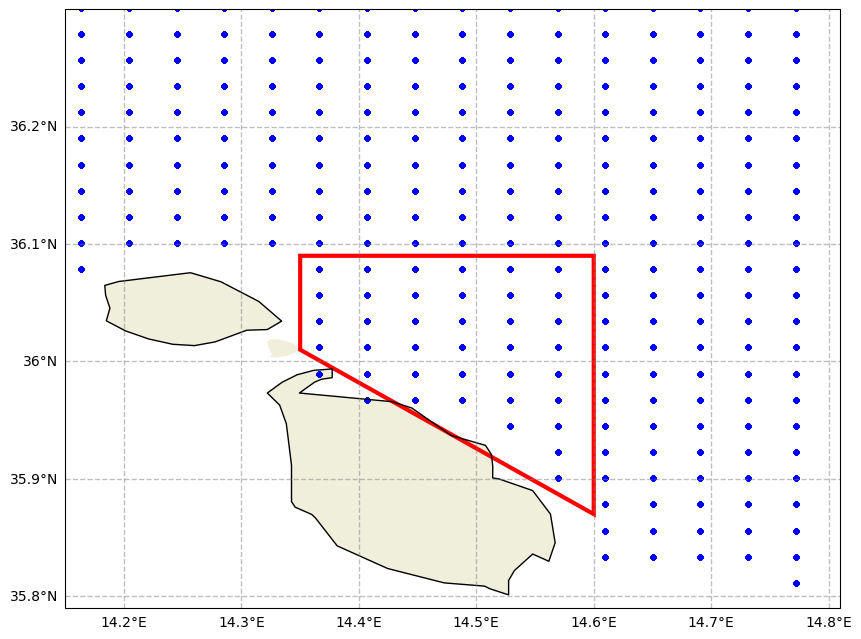

In [5]:
# Define the boundaries for the map 
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3    
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Initialize a matplotlib figure with Cartopy for data visualization
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the viewing extent of the map using the defined boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add features to the map for land, coastlines, and country borders for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot all data points from the dataframe within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Draw a red polygon using the defined coordinates to highlight a specific area on the map
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Add gridlines to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()

### Geospatial Filtering

Filter the dataset to focus on the area of interest:

- **Filtering**: Apply the polygon as a filter to select only data points located inside this area.
- **Visualization**: Plot the filtered data on a map to visually confirm the focus area, marking points within the polygon in red for clarity.
- **Map Features**: Enhance the map with features like land, coastlines, and borders for better context.
- **Final View**: Display the map with the filtered points.

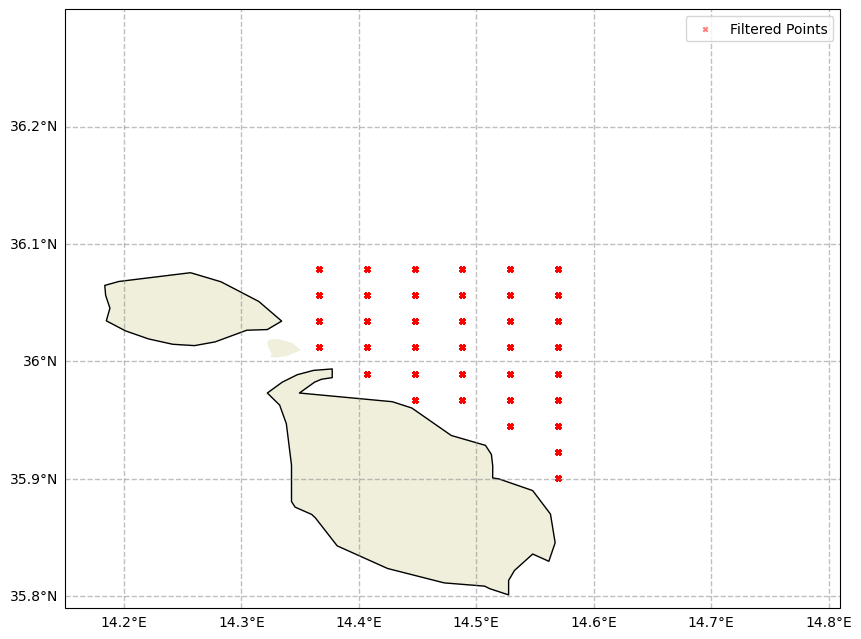

In [6]:
# Convert the list of polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to filter points in the DataFrame that lie inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Initialize a new matplotlib figure with Cartopy for mapping, specifying the projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map to the defined geographic boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add land, coastlines, and country borders to the map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the points that are located within the defined polygon in red
scatter = ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic(), label='Filtered Points')

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add a legend to the plot to explain the red "X" markers
ax.legend(handles=[scatter], loc='upper right')

# Display the plot
plt.show()

### Selecting the coordinates inside the polygon

Identify and processes data points located within the selected area:

- **Path Creation**: Transform the polygon coordinates into a Path object for spatial filtering.
- **Coordinate Pairing**: Combine 'lon' and 'lat' from the DataFrame into coordinate tuples.
- **Spatial Filtering**: Apply the Path object to select only points inside the polygon.
- **Duplicate Removal**: Eliminate duplicate points to ensure unique data entries.
- **Count and Display**: Calculate and print the total number of unique points inside the polygon, along with their coordinates.

In [7]:
# Convert the polygon coordinates to a Path object 
polygon_path = mpath.Path(polygon_coordinates)

# Combine longitude and latitude columns from the DataFrame into a list of tuples for each point
coordinates = list(zip(df['lon'], df['lat']))

# Create a mask to identify which points fall within the defined polygon by checking each point
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Use the mask to filter the DataFrame, keeping only points that are inside the polygon
df_inside_polygon = df[inside_mask]

# Remove potential duplicate entries based on their longitude and latitude
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Calculate the number of unique points found inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Iterate over each coordinate pair inside the polygon and print them out
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.569199562072754, 35.90060043334961)
(14.569199562072754, 35.92279815673828)
(14.569199562072754, 35.945098876953125)
(14.528599739074707, 35.96730041503906)
(14.569199562072754, 35.96730041503906)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.48799991607666, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.48799991607666, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.366399765014648, 36.07870101928711)
(14.406900405883789, 3

### Create a Data Frame for the coordinates inside the polygon

In [8]:
# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the final DataFrame
final_df

time        lat      lon         u   
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436  \
2020-02-25 15:00:00 2020-02-25 15:00:00  35.922798  14.5692  0.209744   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.945099  14.5692  0.165433   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5286  0.139062   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5692  0.162474   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4069  0.148599   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4475  0.153244   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4880  0.165081   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5286  0.169408   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5692  0.178463   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.180382  
2020-02-25 15:00:00 -0.158304  
2020-02-25 15:00:00 -0.155931  
2020-02-25 15:00:00 -0.140758  
...                       ...  
2023-08-01 23:00:00 -0.234722  
2023-08-01 23:00:00 -0.216512  
2023-08-01 23:00:00 -0.183771  
2023-08-01 23:00:00 -0.206215  
2023-08-01 23:00:00 -0.222228  

[366357 rows x 5 columns]

### Data Extraction for Selected Coordinates

Extracting and saving specific sea surface current data for predefined locations within our area of interest:

- **Selected Coordinates**: List the specific latitude and longitude pairs.
- **Data Extraction**: For each pair, filter the main dataset to obtain the relevant data points.
- **File Saving**: Convert latitude and longitude to a format suitable for filenames and save the data as CSV files.

Each data point's latitude and longitude are converted to remove decimal points, ensuring valid filenames. This process results in a set of CSV files, each corresponding to a unique location within the selected polygon.

In [9]:
# Directory to save the files
save_directory = "Data/coordinate_data_frames"
os.makedirs(save_directory, exist_ok=True)

# Coordinates of the points inside the polygon
coordinates_inside = [
    (14.569199562072754, 35.90060043334961),
    (14.569199562072754, 35.92279815673828),
    (14.569199562072754, 35.945098876953125),
    (14.528599739074707, 35.96730041503906),
    (14.569199562072754, 35.96730041503906),
    (14.447500228881836, 35.989601135253906),
    (14.48799991607666, 35.989601135253906),
    (14.528599739074707, 35.989601135253906),
    (14.569199562072754, 35.989601135253906),
    (14.447500228881836, 36.01190185546875),
    (14.48799991607666, 36.01190185546875),
    (14.528599739074707, 36.01190185546875),
    (14.569199562072754, 36.01190185546875),
    (14.447500228881836, 36.03409957885742),
    (14.48799991607666, 36.03409957885742),
    (14.528599739074707, 36.03409957885742),
    (14.569199562072754, 36.03409957885742),
    (14.447500228881836, 36.056400299072266),
    (14.48799991607666, 36.056400299072266),
    (14.528599739074707, 36.056400299072266),
    (14.569199562072754, 36.056400299072266),
    (14.366399765014648, 36.07870101928711),
    (14.406900405883789, 36.07870101928711),
    (14.447500228881836, 36.07870101928711),
    (14.48799991607666, 36.07870101928711),
    (14.528599739074707, 36.07870101928711),
    (14.569199562072754, 36.07870101928711),
    (14.528599739074707, 35.945098876953125),
    (14.406900405883789, 36.03409957885742),
    (14.406900405883789, 36.056400299072266),
    (14.406900405883789, 36.01190185546875),
    (14.366399765014648, 36.03409957885742),
    (14.366399765014648, 36.056400299072266),
    (14.48799991607666, 35.96730041503906),
    (14.406900405883789, 35.989601135253906,),
    (14.366399765014648, 36.01190185546875),
    (14.447500228881836, 35.96730041503906)
]

# Loop through each pair of coordinates along with an index
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Print the current pair being processed
    print(f"Processing pair {index}: (lat: {lat}, lon: {lon})")

    # Filter the DataFrame for the exact coordinates
    df_point = final_df[(final_df['lat'] == lat) & (final_df['lon'] == lon)]

    # Check if any data points were found for the current pair
    if df_point.empty:
        print(f"No data points found for (lat: {lat}, lon: {lon})")
    else:
        print(f"Found {df_point.shape[0]} data points for (lat: {lat}, lon: {lon})")

    # Format the latitude and longitude to remove decimal points and replace with underscores
    lat_formatted = str(lat).replace('.', '_')
    lon_formatted = str(lon).replace('.', '_')

    # Create a unique filename for each pair of coordinates
    filename = f"{index}_{lat_formatted}_{lon_formatted}.csv"
    filepath = os.path.join(save_directory, filename)

    # Save the filtered DataFrame to a CSV file
    df_point.to_csv(filepath, index=False)

    # Confirm that the file has been saved
    print(f"Saved data for (lat: {lat}, lon: {lon}) as {filename}\n")

print("All data processing complete.")
print("="*175)

Processing pair 1: (lat: 35.90060043334961, lon: 14.569199562072754)
Found 6694 data points for (lat: 35.90060043334961, lon: 14.569199562072754)
Saved data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754.csv

Processing pair 2: (lat: 35.92279815673828, lon: 14.569199562072754)
Found 6804 data points for (lat: 35.92279815673828, lon: 14.569199562072754)
Saved data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754.csv

Processing pair 3: (lat: 35.945098876953125, lon: 14.569199562072754)
Found 8293 data points for (lat: 35.945098876953125, lon: 14.569199562072754)
Saved data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754.csv

Processing pair 4: (lat: 35.96730041503906, lon: 14.528599739074707)
Found 9458 data points for (lat: 35.96730041503906, lon: 14.528599739074707)
Saved data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_967

### Model Preparation, Training & Evaluation

- **Model Storage**: Set up a directory to save the trained models.
- **Data Preparation**: List and load all coordinate-specific CSV files that were prepared earlier.
- **Feature Selection**: For each dataset, 'u' and 'v' values are chosen as features with 'u' set as the target variable.
- **Time Series Generation**: Construct time series generators, utilizing the last 72 hours (3 days) of data to predict the 'u' value for the next hour. This historical data frame helps the model understand temporal patterns.
- **Early Stopping**: Integrate early stopping to halt training when the validation loss stops improving, preventing overfitting and saving computational resources.
- **Model Architecture**: Build the LSTM (Long Short-Term Memory) network. The model architecture includes several layers with dropout rates to manage overfitting.
- **Training Process**: Train the model on the generated time series data, monitoring both training and validation metrics.
- **Prediction and Evaluation**:
    - **Prediction**: After training, apply the model to the test set to forecast future 'u' values.
    - **Evaluation Metrics**: Use three key metrics to evaluate model performance:
        - **Mean Squared Error (MSE)**: Represents the average of the squares of the errors between actual and predicted values. Lower values indicate better performance.
        - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between pairs of actual and predicted values, without considering their direction. Lower MAE values signify better accuracy.
        - **Root Mean Squared Error (RMSE)**: The square root of MSE, providing error metrics in the same units as the data, making interpretation straightforward. Lower RMSE values denote better fit.
    - **Visualization**: Plot actual vs. predicted 'u' values to visually assess the model's prediction accuracy and understand its real-world applicability.

['1_35_90060043334961_14_569199562072754.csv', '2_35_92279815673828_14_569199562072754.csv', '3_35_945098876953125_14_569199562072754.csv', '4_35_96730041503906_14_528599739074707.csv', '5_35_96730041503906_14_569199562072754.csv', '6_35_989601135253906_14_447500228881836.csv', '7_35_989601135253906_14_48799991607666.csv', '8_35_989601135253906_14_528599739074707.csv', '9_35_989601135253906_14_569199562072754.csv', '10_36_01190185546875_14_447500228881836.csv', '11_36_01190185546875_14_48799991607666.csv', '12_36_01190185546875_14_528599739074707.csv', '13_36_01190185546875_14_569199562072754.csv', '14_36_03409957885742_14_447500228881836.csv', '15_36_03409957885742_14_48799991607666.csv', '16_36_03409957885742_14_528599739074707.csv', '17_36_03409957885742_14_569199562072754.csv', '18_36_056400299072266_14_447500228881836.csv', '19_36_056400299072266_14_48799991607666.csv', '20_36_056400299072266_14_528599739074707.csv', '21_36_056400299072266_14_569199562072754.csv', '22_36_078701019

C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)



Epoch 1/100

73/73 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.1026INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 39s 439ms/step - loss: 0.0170 - mean_absolute_error: 0.1026 - val_loss: 0.0207 - val_mean_absolute_error: 0.1109
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0895INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 31s 430ms/step - loss: 0.0134 - mean_absolute_error: 0.0895 - val_loss: 0.0155 - val_mean_absolute_error: 0.0907
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 32s 443ms/step - loss: 0.0096 - mean_absolute_error: 0.0721 - val_loss: 0.0127 - val_mean_absolute_error: 0.0767
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0631INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 54s 749ms/step - loss: 0.0079 - mean_absolute_error: 0.0631 - val_loss: 0.0104 - val_mean_absolute_error: 0.0654
Epoch 5/100
73/73 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0575INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 36s 492ms/step - loss: 0.0071 - mean_absolute_error: 0.0575 - val_loss: 0.0095 - val_mean_absolute_error: 0.0597
Epoch 6/100
73/73 [==============================] - 22s 304ms/step - loss: 0.0063 - mean_absolute_error: 0.0540 - val_loss: 0.0101 - val_mean_absolute_error: 0.0629
Epoch 7/100
73/73 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0520INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 32s 435ms/step - loss: 0.0060 - mean_absolute_error: 0.0520 - val_loss: 0.0088 - val_mean_absolute_error: 0.0535
Epoch 8/100
73/73 [==============================] - 22s 306ms/step - loss: 0.0060 - mean_absolute_error: 0.0511 - val_loss: 0.0091 - val_mean_absolute_error: 0.0566
Epoch 9/100
73/73 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0497INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 33s 448ms/step - loss: 0.0057 - mean_absolute_error: 0.0497 - val_loss: 0.0084 - val_mean_absolute_error: 0.0511
Epoch 10/100
73/73 [==============================] - 24s 322ms/step - loss: 0.0057 - mean_absolute_error: 0.0494 - val_loss: 0.0091 - val_mean_absolute_error: 0.0566
Epoch 11/100
73/73 [==============================] - 24s 323ms/step - loss: 0.0057 - mean_absolute_error: 0.0490 - val_loss: 0.0085 - val_mean_absolute_error: 0.0518
Epoch 12/100
73/73 [==============================] - 23s 321ms/step - loss: 0.0057 - mean_absolute_error: 0.0494 - val_loss: 0.0090 - val_mean_absolute_error: 0.0556
Epoch 13/100
73/73 [==============================] - 24s 322ms/step - loss: 0.0055 - mean_absolute_error: 0.0479 - val_loss: 0.0087 - val_mean_absolute_error: 0.0538
Epoch 14/100
73/73 [==============================] - 24s 323ms/step - loss: 0.0055 - mean_absolute_error: 0.0482 - val_loss: 0.0085 - val_mean_absolute_error: 0.0523
Epoch 15/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 33s 459ms/step - loss: 0.0054 - mean_absolute_error: 0.0470 - val_loss: 0.0083 - val_mean_absolute_error: 0.0504
Epoch 16/100
73/73 [==============================] - 25s 342ms/step - loss: 0.0056 - mean_absolute_error: 0.0483 - val_loss: 0.0091 - val_mean_absolute_error: 0.0573
Epoch 17/100
73/73 [==============================] - 24s 334ms/step - loss: 0.0054 - mean_absolute_error: 0.0479 - val_loss: 0.0085 - val_mean_absolute_error: 0.0528
Epoch 18/100
73/73 [==============================] - 25s 339ms/step - loss: 0.0055 - mean_absolute_error: 0.0473 - val_loss: 0.0087 - val_mean_absolute_error: 0.0542
Epoch 19/100
73/73 [==============================] - 24s 333ms/step - loss: 0.0054 - mean_absolute_error: 0.0471 - val_loss: 0.0084 - val_mean_absolute_error: 0.0523
Epoch 20/100
73/73 [==============================] - 25s 342ms/step - loss: 0.0055 - mean_absolute_error: 0.0475 - val_loss: 0.0093 - val_mean_absolute_error: 0.0588
Epoch 21/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 35s 475ms/step - loss: 0.0055 - mean_absolute_error: 0.0478 - val_loss: 0.0083 - val_mean_absolute_error: 0.0517
Epoch 22/100
73/73 [==============================] - 26s 355ms/step - loss: 0.0053 - mean_absolute_error: 0.0470 - val_loss: 0.0086 - val_mean_absolute_error: 0.0541
Epoch 23/100
73/73 [==============================] - 26s 352ms/step - loss: 0.0053 - mean_absolute_error: 0.0469 - val_loss: 0.0086 - val_mean_absolute_error: 0.0539
Epoch 24/100
73/73 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0467INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 36s 490ms/step - loss: 0.0053 - mean_absolute_error: 0.0467 - val_loss: 0.0083 - val_mean_absolute_error: 0.0521
Epoch 25/100
73/73 [==============================] - 26s 362ms/step - loss: 0.0053 - mean_absolute_error: 0.0463 - val_loss: 0.0085 - val_mean_absolute_error: 0.0536
Epoch 26/100
73/73 [==============================] - 26s 362ms/step - loss: 0.0052 - mean_absolute_error: 0.0463 - val_loss: 0.0084 - val_mean_absolute_error: 0.0535
Epoch 27/100
73/73 [==============================] - 26s 362ms/step - loss: 0.0052 - mean_absolute_error: 0.0460 - val_loss: 0.0088 - val_mean_absolute_error: 0.0562
Epoch 28/100
73/73 [==============================] - 26s 363ms/step - loss: 0.0052 - mean_absolute_error: 0.0459 - val_loss: 0.0085 - val_mean_absolute_error: 0.0537
Epoch 29/100
73/73 [==============================] - 27s 367ms/step - loss: 0.0053 - mean_absolute_error: 0.0465 - val_loss: 0.0090 - val_mean_absolute_error: 0.0579
Epoch 30/10

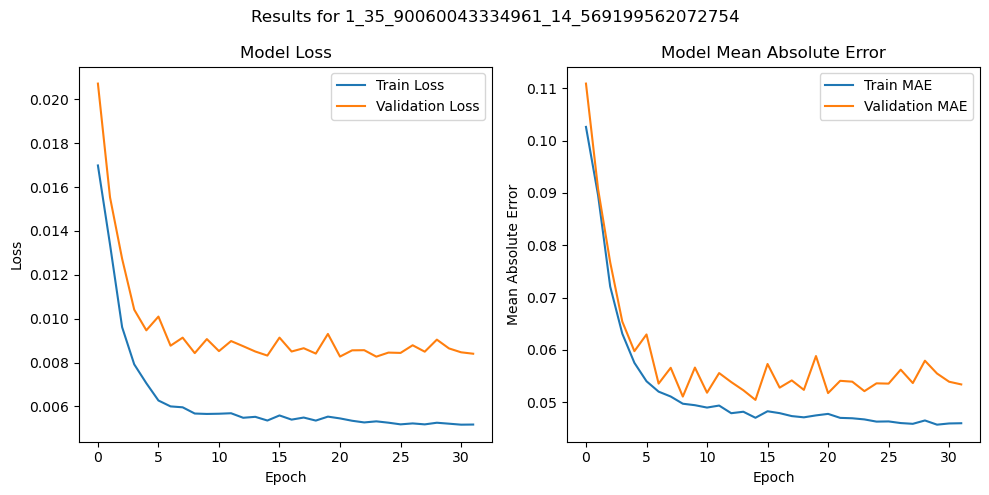

15/15 [==============================] - 3s 126ms/step

Test set Evaluation metrics for file: 1_35_90060043334961_14_569199562072754
Mean Squared Error (MSE): 0.00339192702691718
Mean Absolute Error (MAE): 0.04063030896044129
Root Mean Squared Error (RMSE): 0.05824025263438664



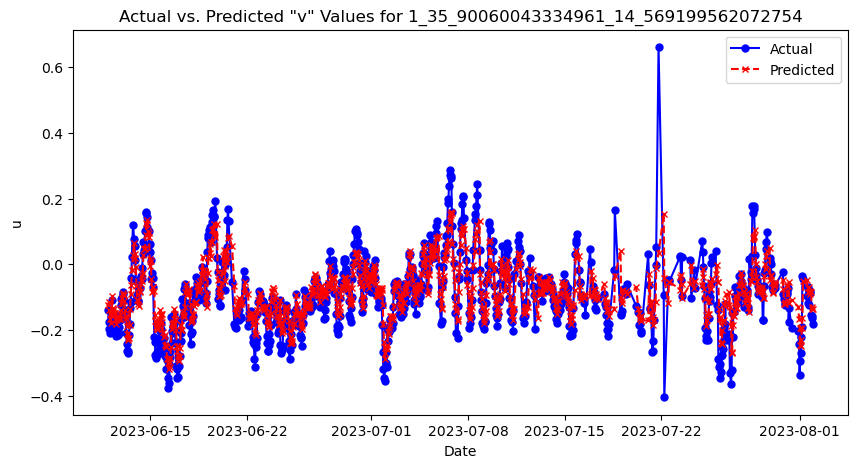

Model tarining & evaluation completed for file: 1_35_90060043334961_14_569199562072754.csv

Processing file: 2_35_92279815673828_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.1021INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 52s 623ms/step - loss: 0.0166 - mean_absolute_error: 0.1021 - val_loss: 0.0228 - val_mean_absolute_error: 0.1135
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0857INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 42s 575ms/step - loss: 0.0124 - mean_absolute_error: 0.0857 - val_loss: 0.0163 - val_mean_absolute_error: 0.0903
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 42s 569ms/step - loss: 0.0091 - mean_absolute_error: 0.0701 - val_loss: 0.0117 - val_mean_absolute_error: 0.0677
Epoch 4/100
74/74 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0604INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 41s 554ms/step - loss: 0.0073 - mean_absolute_error: 0.0604 - val_loss: 0.0109 - val_mean_absolute_error: 0.0641
Epoch 5/100
74/74 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0562INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 42s 563ms/step - loss: 0.0066 - mean_absolute_error: 0.0562 - val_loss: 0.0099 - val_mean_absolute_error: 0.0568
Epoch 6/100
74/74 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0535INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 43s 581ms/step - loss: 0.0062 - mean_absolute_error: 0.0535 - val_loss: 0.0095 - val_mean_absolute_error: 0.0531
Epoch 7/100
74/74 [==============================] - 51s 695ms/step - loss: 0.0056 - mean_absolute_error: 0.0500 - val_loss: 0.0095 - val_mean_absolute_error: 0.0531
Epoch 8/100
74/74 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0490INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 63s 857ms/step - loss: 0.0056 - mean_absolute_error: 0.0490 - val_loss: 0.0094 - val_mean_absolute_error: 0.0516
Epoch 9/100
74/74 [==============================] - 43s 575ms/step - loss: 0.0054 - mean_absolute_error: 0.0473 - val_loss: 0.0095 - val_mean_absolute_error: 0.0519
Epoch 10/100
74/74 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0470INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 52s 709ms/step - loss: 0.0053 - mean_absolute_error: 0.0470 - val_loss: 0.0093 - val_mean_absolute_error: 0.0504
Epoch 11/100
74/74 [==============================] - 42s 564ms/step - loss: 0.0050 - mean_absolute_error: 0.0457 - val_loss: 0.0096 - val_mean_absolute_error: 0.0520
Epoch 12/100
74/74 [==============================] - 42s 562ms/step - loss: 0.0050 - mean_absolute_error: 0.0458 - val_loss: 0.0094 - val_mean_absolute_error: 0.0511
Epoch 13/100
74/74 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0462INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 55s 740ms/step - loss: 0.0052 - mean_absolute_error: 0.0462 - val_loss: 0.0093 - val_mean_absolute_error: 0.0493
Epoch 14/100
74/74 [==============================] - 45s 614ms/step - loss: 0.0052 - mean_absolute_error: 0.0467 - val_loss: 0.0093 - val_mean_absolute_error: 0.0497
Epoch 15/100
74/74 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 60s 815ms/step - loss: 0.0051 - mean_absolute_error: 0.0461 - val_loss: 0.0092 - val_mean_absolute_error: 0.0492
Epoch 16/100
74/74 [==============================] - 42s 561ms/step - loss: 0.0050 - mean_absolute_error: 0.0452 - val_loss: 0.0094 - val_mean_absolute_error: 0.0510
Epoch 17/100
74/74 [==============================] - 48s 651ms/step - loss: 0.0050 - mean_absolute_error: 0.0450 - val_loss: 0.0095 - val_mean_absolute_error: 0.0529
Epoch 18/100
74/74 [==============================] - 42s 573ms/step - loss: 0.0050 - mean_absolute_error: 0.0455 - val_loss: 0.0092 - val_mean_absolute_error: 0.0512
Epoch 19/100
74/74 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0446INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 52s 711ms/step - loss: 0.0049 - mean_absolute_error: 0.0446 - val_loss: 0.0089 - val_mean_absolute_error: 0.0474
Epoch 20/100
74/74 [==============================] - 42s 570ms/step - loss: 0.0050 - mean_absolute_error: 0.0446 - val_loss: 0.0096 - val_mean_absolute_error: 0.0535
Epoch 21/100
74/74 [==============================] - 42s 563ms/step - loss: 0.0049 - mean_absolute_error: 0.0443 - val_loss: 0.0093 - val_mean_absolute_error: 0.0521
Epoch 22/100
74/74 [==============================] - 41s 556ms/step - loss: 0.0048 - mean_absolute_error: 0.0443 - val_loss: 0.0090 - val_mean_absolute_error: 0.0491
Epoch 23/100
74/74 [==============================] - 41s 557ms/step - loss: 0.0049 - mean_absolute_error: 0.0441 - val_loss: 0.0093 - val_mean_absolute_error: 0.0519
Epoch 24/100
74/74 [==============================] - 41s 557ms/step - loss: 0.0048 - mean_absolute_error: 0.0439 - val_loss: 0.0091 - val_mean_absolute_error: 0.0498
Epoch 25/10

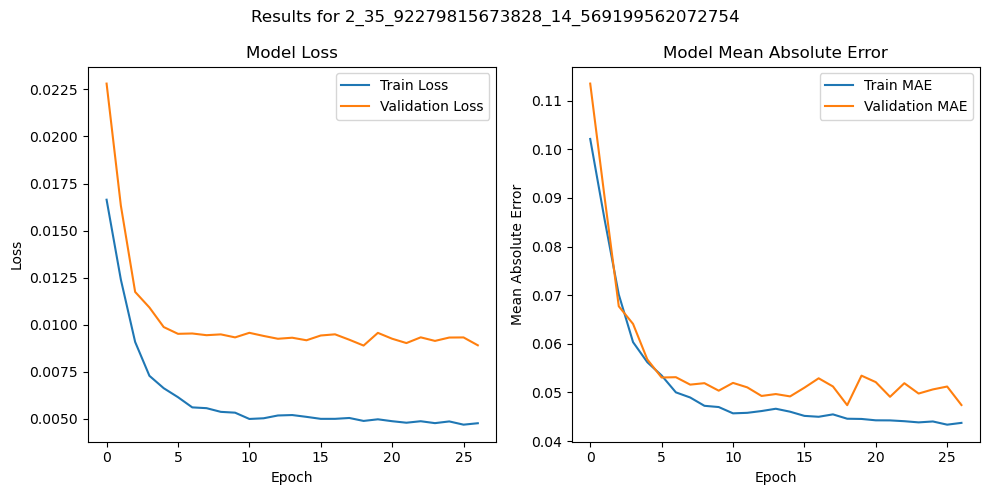

15/15 [==============================] - 5s 185ms/step

Test set Evaluation metrics for file: 2_35_92279815673828_14_569199562072754
Mean Squared Error (MSE): 0.0029051890954704227
Mean Absolute Error (MAE): 0.037157221849894784
Root Mean Squared Error (RMSE): 0.0538998060800818



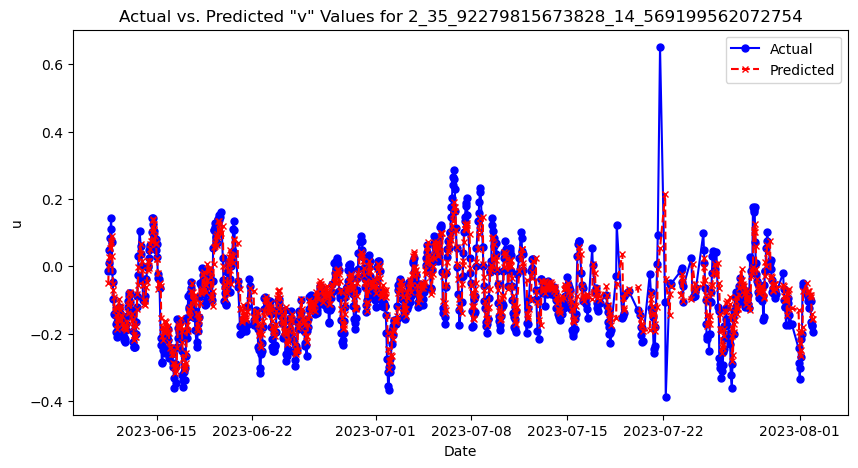

Model tarining & evaluation completed for file: 2_35_92279815673828_14_569199562072754.csv

Processing file: 3_35_945098876953125_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0962INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 64s 641ms/step - loss: 0.0150 - mean_absolute_error: 0.0962 - val_loss: 0.0181 - val_mean_absolute_error: 0.1026
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0793INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 75s 830ms/step - loss: 0.0109 - mean_absolute_error: 0.0793 - val_loss: 0.0124 - val_mean_absolute_error: 0.0768
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0638INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 74s 827ms/step - loss: 0.0076 - mean_absolute_error: 0.0638 - val_loss: 0.0099 - val_mean_absolute_error: 0.0644
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0556INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 81s 899ms/step - loss: 0.0062 - mean_absolute_error: 0.0556 - val_loss: 0.0089 - val_mean_absolute_error: 0.0599
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0494INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 87s 966ms/step - loss: 0.0053 - mean_absolute_error: 0.0494 - val_loss: 0.0083 - val_mean_absolute_error: 0.0557
Epoch 6/100
90/90 [==============================] - 77s 859ms/step - loss: 0.0051 - mean_absolute_error: 0.0480 - val_loss: 0.0087 - val_mean_absolute_error: 0.0584
Epoch 7/100
90/90 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 93s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0461 - val_loss: 0.0074 - val_mean_absolute_error: 0.0481
Epoch 8/100
90/90 [==============================] - 50s 554ms/step - loss: 0.0047 - mean_absolute_error: 0.0442 - val_loss: 0.0075 - val_mean_absolute_error: 0.0493
Epoch 9/100
90/90 [==============================] - 50s 554ms/step - loss: 0.0048 - mean_absolute_error: 0.0448 - val_loss: 0.0078 - val_mean_absolute_error: 0.0520
Epoch 10/100
90/90 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0437INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 60s 669ms/step - loss: 0.0047 - mean_absolute_error: 0.0437 - val_loss: 0.0072 - val_mean_absolute_error: 0.0466
Epoch 11/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0046 - mean_absolute_error: 0.0438 - val_loss: 0.0077 - val_mean_absolute_error: 0.0509
Epoch 12/100
90/90 [==============================] - 50s 555ms/step - loss: 0.0044 - mean_absolute_error: 0.0427 - val_loss: 0.0076 - val_mean_absolute_error: 0.0495
Epoch 13/100
90/90 [==============================] - 49s 549ms/step - loss: 0.0046 - mean_absolute_error: 0.0434 - val_loss: 0.0073 - val_mean_absolute_error: 0.0466
Epoch 14/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0045 - mean_absolute_error: 0.0427 - val_loss: 0.0074 - val_mean_absolute_error: 0.0480
Epoch 15/100
90/90 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0424INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 60s 668ms/step - loss: 0.0044 - mean_absolute_error: 0.0424 - val_loss: 0.0071 - val_mean_absolute_error: 0.0452
Epoch 16/100
90/90 [==============================] - 50s 554ms/step - loss: 0.0045 - mean_absolute_error: 0.0430 - val_loss: 0.0073 - val_mean_absolute_error: 0.0468
Epoch 17/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0044 - mean_absolute_error: 0.0420 - val_loss: 0.0073 - val_mean_absolute_error: 0.0463
Epoch 18/100
90/90 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0415INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 60s 668ms/step - loss: 0.0042 - mean_absolute_error: 0.0415 - val_loss: 0.0071 - val_mean_absolute_error: 0.0439
Epoch 19/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0045 - mean_absolute_error: 0.0424 - val_loss: 0.0074 - val_mean_absolute_error: 0.0473
Epoch 20/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0043 - mean_absolute_error: 0.0418 - val_loss: 0.0074 - val_mean_absolute_error: 0.0474
Epoch 21/100
90/90 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0399INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 60s 671ms/step - loss: 0.0040 - mean_absolute_error: 0.0399 - val_loss: 0.0070 - val_mean_absolute_error: 0.0423
Epoch 22/100
90/90 [==============================] - 49s 548ms/step - loss: 0.0040 - mean_absolute_error: 0.0399 - val_loss: 0.0075 - val_mean_absolute_error: 0.0477
Epoch 23/100
90/90 [==============================] - 50s 551ms/step - loss: 0.0041 - mean_absolute_error: 0.0406 - val_loss: 0.0075 - val_mean_absolute_error: 0.0476
Epoch 24/100
90/90 [==============================] - 53s 590ms/step - loss: 0.0040 - mean_absolute_error: 0.0399 - val_loss: 0.0074 - val_mean_absolute_error: 0.0471
Epoch 25/100
90/90 [==============================] - 52s 577ms/step - loss: 0.0041 - mean_absolute_error: 0.0406 - val_loss: 0.0075 - val_mean_absolute_error: 0.0473
Epoch 26/100
90/90 [==============================] - 51s 563ms/step - loss: 0.0039 - mean_absolute_error: 0.0400 - val_loss: 0.0076 - val_mean_absolute_error: 0.0472
Epoch 27/10

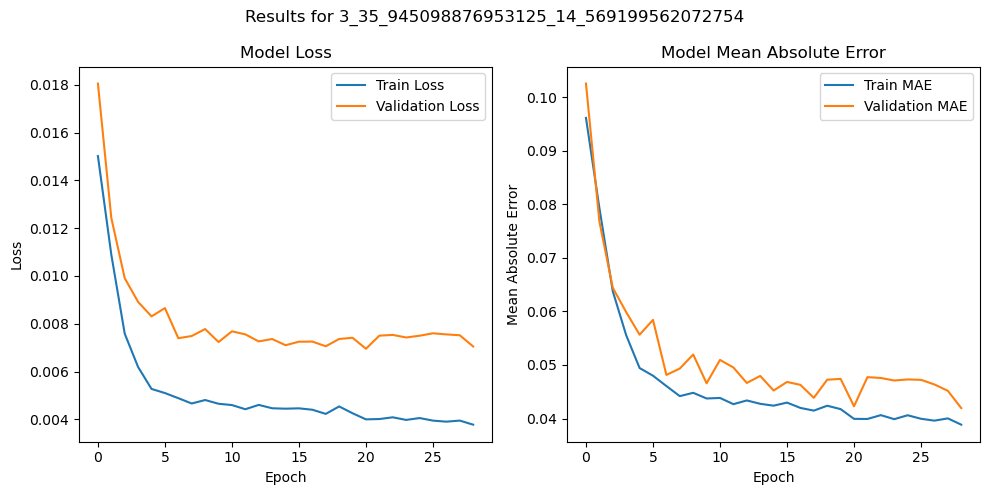

19/19 [==============================] - 5s 177ms/step

Test set Evaluation metrics for file: 3_35_945098876953125_14_569199562072754
Mean Squared Error (MSE): 0.0020069483627928692
Mean Absolute Error (MAE): 0.03196009809954665
Root Mean Squared Error (RMSE): 0.044798977251639005



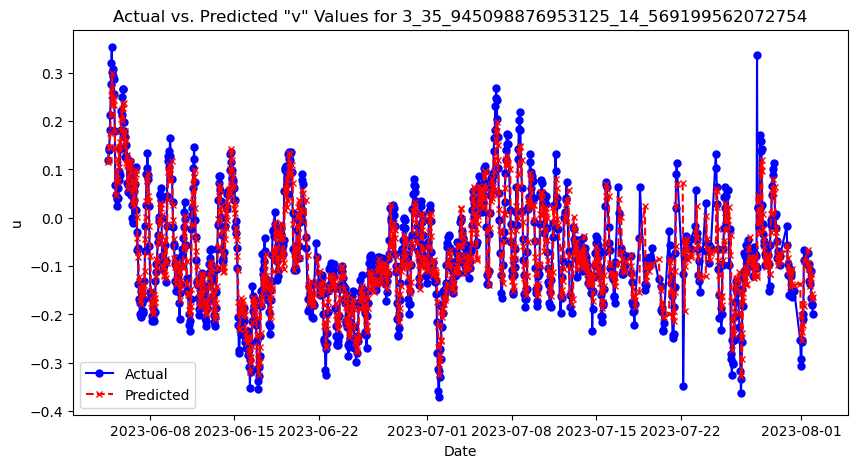

Model tarining & evaluation completed for file: 3_35_945098876953125_14_569199562072754.csv

Processing file: 4_35_96730041503906_14_528599739074707.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.1019INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 89s 808ms/step - loss: 0.0174 - mean_absolute_error: 0.1019 - val_loss: 0.0193 - val_mean_absolute_error: 0.1008
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0890INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 84s 813ms/step - loss: 0.0136 - mean_absolute_error: 0.0890 - val_loss: 0.0157 - val_mean_absolute_error: 0.0875
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0723INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 81s 791ms/step - loss: 0.0098 - mean_absolute_error: 0.0723 - val_loss: 0.0128 - val_mean_absolute_error: 0.0755
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0614INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 92s 890ms/step - loss: 0.0075 - mean_absolute_error: 0.0614 - val_loss: 0.0115 - val_mean_absolute_error: 0.0681
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0546INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 87s 841ms/step - loss: 0.0065 - mean_absolute_error: 0.0546 - val_loss: 0.0106 - val_mean_absolute_error: 0.0637
Epoch 6/100
103/103 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0516INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 100s 975ms/step - loss: 0.0060 - mean_absolute_error: 0.0516 - val_loss: 0.0101 - val_mean_absolute_error: 0.0608
Epoch 7/100
103/103 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0490INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 105s 1s/step - loss: 0.0055 - mean_absolute_error: 0.0490 - val_loss: 0.0096 - val_mean_absolute_error: 0.0569
Epoch 8/100
103/103 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 95s 921ms/step - loss: 0.0053 - mean_absolute_error: 0.0471 - val_loss: 0.0095 - val_mean_absolute_error: 0.0564
Epoch 9/100
103/103 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0468INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 94s 918ms/step - loss: 0.0053 - mean_absolute_error: 0.0468 - val_loss: 0.0095 - val_mean_absolute_error: 0.0560
Epoch 10/100
103/103 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0467INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 93s 903ms/step - loss: 0.0053 - mean_absolute_error: 0.0467 - val_loss: 0.0095 - val_mean_absolute_error: 0.0555
Epoch 11/100
103/103 [==============================] - 100s 969ms/step - loss: 0.0053 - mean_absolute_error: 0.0465 - val_loss: 0.0098 - val_mean_absolute_error: 0.0582
Epoch 12/100
103/103 [==============================] - 102s 989ms/step - loss: 0.0053 - mean_absolute_error: 0.0461 - val_loss: 0.0099 - val_mean_absolute_error: 0.0588
Epoch 13/100
103/103 [==============================] - 101s 982ms/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0096 - val_mean_absolute_error: 0.0571
Epoch 14/100
103/103 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0455INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 118s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0088 - val_mean_absolute_error: 0.0511
Epoch 15/100
103/103 [==============================] - 91s 880ms/step - loss: 0.0049 - mean_absolute_error: 0.0441 - val_loss: 0.0093 - val_mean_absolute_error: 0.0548
Epoch 16/100
103/103 [==============================] - 92s 896ms/step - loss: 0.0049 - mean_absolute_error: 0.0443 - val_loss: 0.0101 - val_mean_absolute_error: 0.0598
Epoch 17/100
103/103 [==============================] - 89s 864ms/step - loss: 0.0047 - mean_absolute_error: 0.0429 - val_loss: 0.0093 - val_mean_absolute_error: 0.0556
Epoch 18/100
103/103 [==============================] - 91s 880ms/step - loss: 0.0047 - mean_absolute_error: 0.0431 - val_loss: 0.0094 - val_mean_absolute_error: 0.0541
Epoch 19/100
103/103 [==============================] - 90s 871ms/step - loss: 0.0046 - mean_absolute_error: 0.0424 - val_loss: 0.0097 - val_mean_absolute_error: 0.0571
E

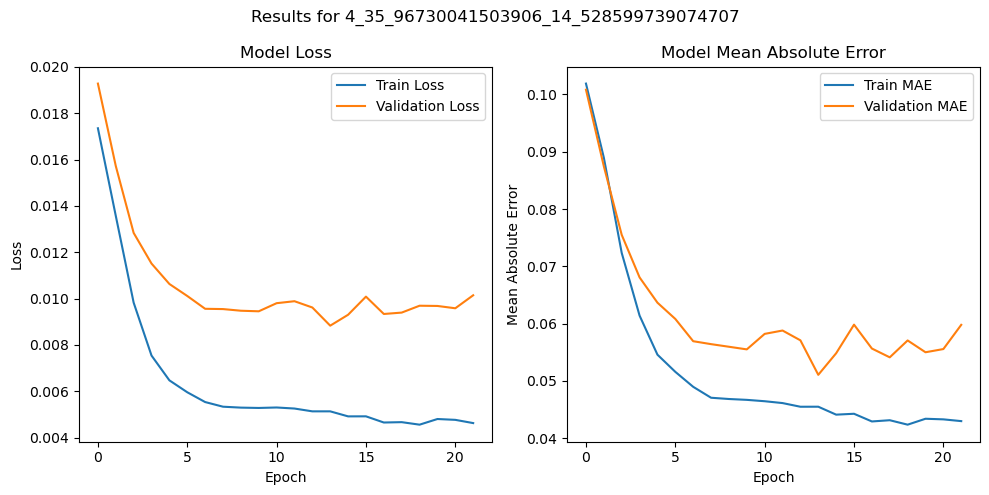

22/22 [==============================] - 8s 295ms/step

Test set Evaluation metrics for file: 4_35_96730041503906_14_528599739074707
Mean Squared Error (MSE): 0.002935680742859901
Mean Absolute Error (MAE): 0.0409494334045291
Root Mean Squared Error (RMSE): 0.054181922657468524



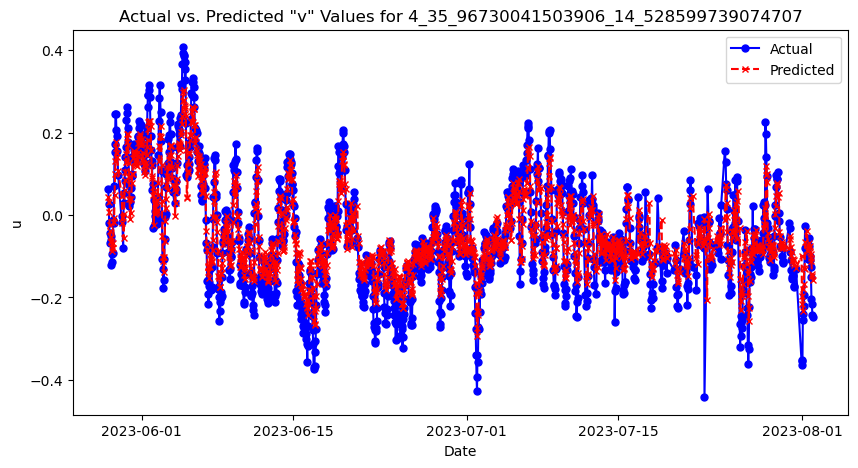

Model tarining & evaluation completed for file: 4_35_96730041503906_14_528599739074707.csv

Processing file: 5_35_96730041503906_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0971INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 114s 1s/step - loss: 0.0157 - mean_absolute_error: 0.0971 - val_loss: 0.0149 - val_mean_absolute_error: 0.0902
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0809INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 101s 982ms/step - loss: 0.0114 - mean_absolute_error: 0.0809 - val_loss: 0.0111 - val_mean_absolute_error: 0.0735
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0662INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 127s 1s/step - loss: 0.0083 - mean_absolute_error: 0.0662 - val_loss: 0.0092 - val_mean_absolute_error: 0.0641
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0572INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 109s 1s/step - loss: 0.0067 - mean_absolute_error: 0.0572 - val_loss: 0.0082 - val_mean_absolute_error: 0.0580
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0517INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 103s 999ms/step - loss: 0.0059 - mean_absolute_error: 0.0517 - val_loss: 0.0076 - val_mean_absolute_error: 0.0548
Epoch 6/100
103/103 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0483INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 119s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0483 - val_loss: 0.0073 - val_mean_absolute_error: 0.0529
Epoch 7/100
103/103 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0465INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 107s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0465 - val_loss: 0.0068 - val_mean_absolute_error: 0.0488
Epoch 8/100
103/103 [==============================] - 97s 938ms/step - loss: 0.0050 - mean_absolute_error: 0.0449 - val_loss: 0.0068 - val_mean_absolute_error: 0.0487
Epoch 9/100
103/103 [==============================] - 96s 933ms/step - loss: 0.0049 - mean_absolute_error: 0.0446 - val_loss: 0.0069 - val_mean_absolute_error: 0.0487
Epoch 10/100
103/103 [==============================] - 96s 937ms/step - loss: 0.0049 - mean_absolute_error: 0.0443 - val_loss: 0.0069 - val_mean_absolute_error: 0.0484
Epoch 11/100
103/103 [==============================] - 101s 980ms/step - loss: 0.0047 - mean_absolute_error: 0.0433 - val_loss: 0.0069 - val_mean_absolute_error: 0.0485
Epoch 12/100
103/103 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0432INFO:tensorflow:Assets written to: Data/saved_models/LSTM/model

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 109s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0432 - val_loss: 0.0066 - val_mean_absolute_error: 0.0462
Epoch 13/100
103/103 [==============================] - 132s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0432 - val_loss: 0.0069 - val_mean_absolute_error: 0.0490
Epoch 14/100
103/103 [==============================] - 128s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0429 - val_loss: 0.0072 - val_mean_absolute_error: 0.0507
Epoch 15/100
103/103 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0429INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 144s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0429 - val_loss: 0.0063 - val_mean_absolute_error: 0.0442
Epoch 16/100
103/103 [==============================] - 90s 877ms/step - loss: 0.0046 - mean_absolute_error: 0.0423 - val_loss: 0.0064 - val_mean_absolute_error: 0.0441
Epoch 17/100
103/103 [==============================] - 91s 882ms/step - loss: 0.0046 - mean_absolute_error: 0.0422 - val_loss: 0.0066 - val_mean_absolute_error: 0.0453
Epoch 18/100
103/103 [==============================] - 90s 876ms/step - loss: 0.0046 - mean_absolute_error: 0.0422 - val_loss: 0.0066 - val_mean_absolute_error: 0.0468
Epoch 19/100
103/103 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0405INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 102s 992ms/step - loss: 0.0043 - mean_absolute_error: 0.0405 - val_loss: 0.0061 - val_mean_absolute_error: 0.0417
Epoch 20/100
103/103 [==============================] - 91s 882ms/step - loss: 0.0044 - mean_absolute_error: 0.0409 - val_loss: 0.0065 - val_mean_absolute_error: 0.0446
Epoch 21/100
103/103 [==============================] - 92s 892ms/step - loss: 0.0044 - mean_absolute_error: 0.0407 - val_loss: 0.0067 - val_mean_absolute_error: 0.0465
Epoch 22/100
103/103 [==============================] - 91s 888ms/step - loss: 0.0043 - mean_absolute_error: 0.0407 - val_loss: 0.0064 - val_mean_absolute_error: 0.0429
Epoch 23/100
103/103 [==============================] - 91s 887ms/step - loss: 0.0042 - mean_absolute_error: 0.0397 - val_loss: 0.0065 - val_mean_absolute_error: 0.0443
Epoch 24/100
103/103 [==============================] - 92s 895ms/step - loss: 0.0043 - mean_absolute_error: 0.0402 - val_loss: 0.0065 - val_mean_absolute_error: 0.042

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 104s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0399 - val_loss: 0.0061 - val_mean_absolute_error: 0.0399
Epoch 26/100
103/103 [==============================] - 89s 867ms/step - loss: 0.0043 - mean_absolute_error: 0.0400 - val_loss: 0.0067 - val_mean_absolute_error: 0.0445
Epoch 27/100
103/103 [==============================] - 90s 876ms/step - loss: 0.0041 - mean_absolute_error: 0.0392 - val_loss: 0.0065 - val_mean_absolute_error: 0.0426
Epoch 28/100
103/103 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0400INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 98s 955ms/step - loss: 0.0042 - mean_absolute_error: 0.0400 - val_loss: 0.0061 - val_mean_absolute_error: 0.0404
Epoch 29/100
103/103 [==============================] - 141s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0391 - val_loss: 0.0061 - val_mean_absolute_error: 0.0410
Epoch 30/100
103/103 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0390INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 152s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0390 - val_loss: 0.0059 - val_mean_absolute_error: 0.0391
Epoch 31/100
103/103 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0392INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 114s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0392 - val_loss: 0.0059 - val_mean_absolute_error: 0.0377
Epoch 32/100
103/103 [==============================] - 104s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0400 - val_loss: 0.0062 - val_mean_absolute_error: 0.0410
Epoch 33/100
103/103 [==============================] - 108s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0387 - val_loss: 0.0066 - val_mean_absolute_error: 0.0440
Epoch 34/100
103/103 [==============================] - 108s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0391 - val_loss: 0.0060 - val_mean_absolute_error: 0.0394
Epoch 35/100
103/103 [==============================] - 107s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0390 - val_loss: 0.0061 - val_mean_absolute_error: 0.0405
Epoch 36/100
103/103 [==============================] - 109s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0386 - val_loss: 0.0063 - val_mean_absolute_error: 0.0415
Epoch 37/10

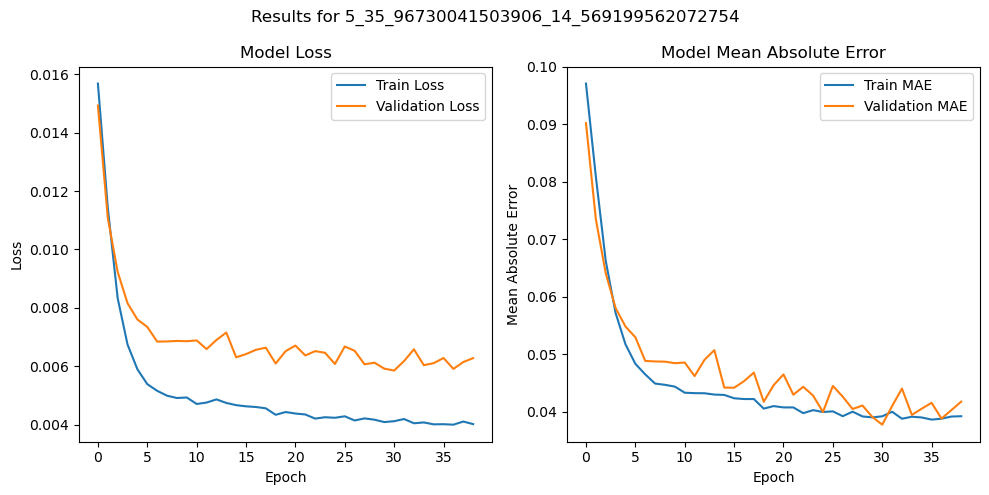

22/22 [==============================] - 9s 344ms/step

Test set Evaluation metrics for file: 5_35_96730041503906_14_569199562072754
Mean Squared Error (MSE): 0.002034600394541645
Mean Absolute Error (MAE): 0.031175283035997044
Root Mean Squared Error (RMSE): 0.04510654491913169



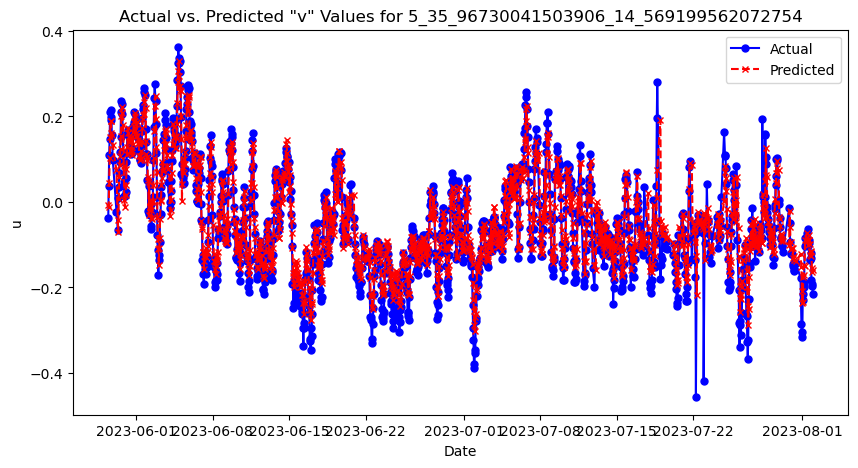

Model tarining & evaluation completed for file: 5_35_96730041503906_14_569199562072754.csv

Processing file: 6_35_989601135253906_14_447500228881836.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.1222INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 89s 1s/step - loss: 0.0244 - mean_absolute_error: 0.1222 - val_loss: 0.0199 - val_mean_absolute_error: 0.1082
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.1134INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 81s 1s/step - loss: 0.0212 - mean_absolute_error: 0.1134 - val_loss: 0.0171 - val_mean_absolute_error: 0.0992
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.1086INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 80s 1s/step - loss: 0.0196 - mean_absolute_error: 0.1086 - val_loss: 0.0160 - val_mean_absolute_error: 0.0976
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0989INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 102s 1s/step - loss: 0.0165 - mean_absolute_error: 0.0989 - val_loss: 0.0132 - val_mean_absolute_error: 0.0870
Epoch 5/100
73/73 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0879INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 100s 1s/step - loss: 0.0136 - mean_absolute_error: 0.0879 - val_loss: 0.0119 - val_mean_absolute_error: 0.0824
Epoch 6/100
73/73 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0820INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 92s 1s/step - loss: 0.0121 - mean_absolute_error: 0.0820 - val_loss: 0.0099 - val_mean_absolute_error: 0.0722
Epoch 7/100
73/73 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0760INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 92s 1s/step - loss: 0.0109 - mean_absolute_error: 0.0760 - val_loss: 0.0088 - val_mean_absolute_error: 0.0671
Epoch 8/100
73/73 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0734INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 88s 1s/step - loss: 0.0103 - mean_absolute_error: 0.0734 - val_loss: 0.0083 - val_mean_absolute_error: 0.0639
Epoch 9/100
73/73 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0734INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 94s 1s/step - loss: 0.0102 - mean_absolute_error: 0.0734 - val_loss: 0.0082 - val_mean_absolute_error: 0.0636
Epoch 10/100
73/73 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0711INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 99s 1s/step - loss: 0.0098 - mean_absolute_error: 0.0711 - val_loss: 0.0079 - val_mean_absolute_error: 0.0605
Epoch 11/100
73/73 [==============================] - 81s 1s/step - loss: 0.0099 - mean_absolute_error: 0.0710 - val_loss: 0.0081 - val_mean_absolute_error: 0.0622
Epoch 12/100
73/73 [==============================] - 79s 1s/step - loss: 0.0099 - mean_absolute_error: 0.0713 - val_loss: 0.0079 - val_mean_absolute_error: 0.0616
Epoch 13/100
73/73 [==============================] - 78s 1s/step - loss: 0.0098 - mean_absolute_error: 0.0708 - val_loss: 0.0080 - val_mean_absolute_error: 0.0616
Epoch 14/100
73/73 [==============================] - 74s 1s/step - loss: 0.0096 - mean_absolute_error: 0.0706 - val_loss: 0.0080 - val_mean_absolute_error: 0.0610
Epoch 15/100
73/73 [==============================] - 71s 973ms/step - loss: 0.0098 - mean_absolute_error: 0.0711 - val_loss: 0.0082 - val_mean_absolute_error: 0.0632
Epoch 16/100
73/73 [======

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 90s 1s/step - loss: 0.0098 - mean_absolute_error: 0.0700 - val_loss: 0.0076 - val_mean_absolute_error: 0.0595
Epoch 17/100
73/73 [==============================] - 70s 955ms/step - loss: 0.0098 - mean_absolute_error: 0.0706 - val_loss: 0.0079 - val_mean_absolute_error: 0.0613
Epoch 18/100
73/73 [==============================] - 71s 980ms/step - loss: 0.0097 - mean_absolute_error: 0.0699 - val_loss: 0.0076 - val_mean_absolute_error: 0.0590
Epoch 19/100
73/73 [==============================] - 68s 933ms/step - loss: 0.0099 - mean_absolute_error: 0.0708 - val_loss: 0.0082 - val_mean_absolute_error: 0.0628
Epoch 20/100
73/73 [==============================] - 69s 943ms/step - loss: 0.0097 - mean_absolute_error: 0.0703 - val_loss: 0.0077 - val_mean_absolute_error: 0.0596
Epoch 21/100
73/73 [==============================] - 69s 940ms/step - loss: 0.0094 - mean_absolute_error: 0.0696 - val_loss: 0.0079 - val_mean_absolute_error: 0.0614
Epoch 22/100
7

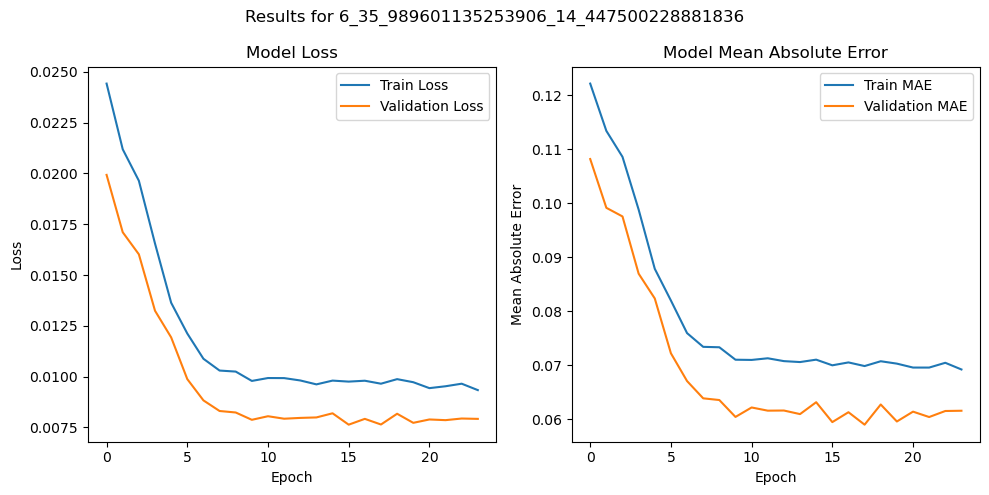

15/15 [==============================] - 6s 336ms/step

Test set Evaluation metrics for file: 6_35_989601135253906_14_447500228881836
Mean Squared Error (MSE): 0.007474746863989732
Mean Absolute Error (MAE): 0.060486756642562166
Root Mean Squared Error (RMSE): 0.08645661839321343



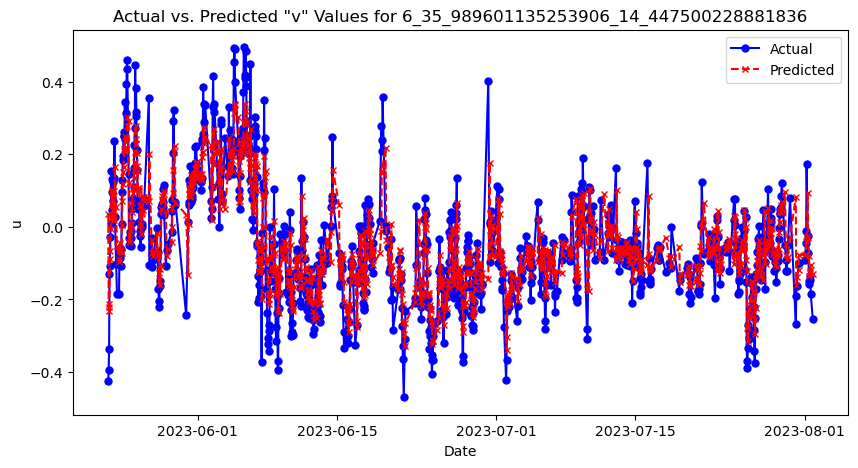

Model tarining & evaluation completed for file: 6_35_989601135253906_14_447500228881836.csv

Processing file: 7_35_989601135253906_14_48799991607666.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.1099INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 116s 1s/step - loss: 0.0203 - mean_absolute_error: 0.1099 - val_loss: 0.0189 - val_mean_absolute_error: 0.1029
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.1021INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 121s 1s/step - loss: 0.0174 - mean_absolute_error: 0.1021 - val_loss: 0.0162 - val_mean_absolute_error: 0.0957
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0890INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 122s 1s/step - loss: 0.0137 - mean_absolute_error: 0.0890 - val_loss: 0.0105 - val_mean_absolute_error: 0.0767
Epoch 4/100
106/106 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 146s 1s/step - loss: 0.0096 - mean_absolute_error: 0.0726 - val_loss: 0.0089 - val_mean_absolute_error: 0.0703
Epoch 5/100
106/106 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0654INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 146s 1s/step - loss: 0.0079 - mean_absolute_error: 0.0654 - val_loss: 0.0075 - val_mean_absolute_error: 0.0638
Epoch 6/100
106/106 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0599INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 145s 1s/step - loss: 0.0068 - mean_absolute_error: 0.0599 - val_loss: 0.0061 - val_mean_absolute_error: 0.0564
Epoch 7/100
106/106 [==============================] - 132s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0560 - val_loss: 0.0068 - val_mean_absolute_error: 0.0605
Epoch 8/100
106/106 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0548INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 144s 1s/step - loss: 0.0059 - mean_absolute_error: 0.0548 - val_loss: 0.0053 - val_mean_absolute_error: 0.0522
Epoch 9/100
106/106 [==============================] - 135s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0526 - val_loss: 0.0054 - val_mean_absolute_error: 0.0525
Epoch 10/100
106/106 [==============================] - 135s 1s/step - loss: 0.0057 - mean_absolute_error: 0.0532 - val_loss: 0.0057 - val_mean_absolute_error: 0.0539
Epoch 11/100
106/106 [==============================] - 135s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0529 - val_loss: 0.0058 - val_mean_absolute_error: 0.0546
Epoch 12/100
106/106 [==============================] - 135s 1s/step - loss: 0.0057 - mean_absolute_error: 0.0532 - val_loss: 0.0060 - val_mean_absolute_error: 0.0557
Epoch 13/100
106/106 [==============================] - 135s 1s/step - loss: 0.0057 - mean_absolute_error: 0.0530 - val_loss: 0.0056 - val_mean_absolute_error: 0.0535
Epoch 14/100

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 145s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0517 - val_loss: 0.0052 - val_mean_absolute_error: 0.0509
Epoch 16/100
106/106 [==============================] - 135s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0062 - val_mean_absolute_error: 0.0571
Epoch 17/100
106/106 [==============================] - 134s 1s/step - loss: 0.0055 - mean_absolute_error: 0.0519 - val_loss: 0.0059 - val_mean_absolute_error: 0.0554
Epoch 18/100
106/106 [==============================] - 135s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0512 - val_loss: 0.0060 - val_mean_absolute_error: 0.0555
Epoch 19/100
106/106 [==============================] - 135s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0514 - val_loss: 0.0061 - val_mean_absolute_error: 0.0562
Epoch 20/100
106/106 [==============================] - 134s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0519 - val_loss: 0.0063 - val_mean_absolute_error: 0.0574
Epoch 21/10

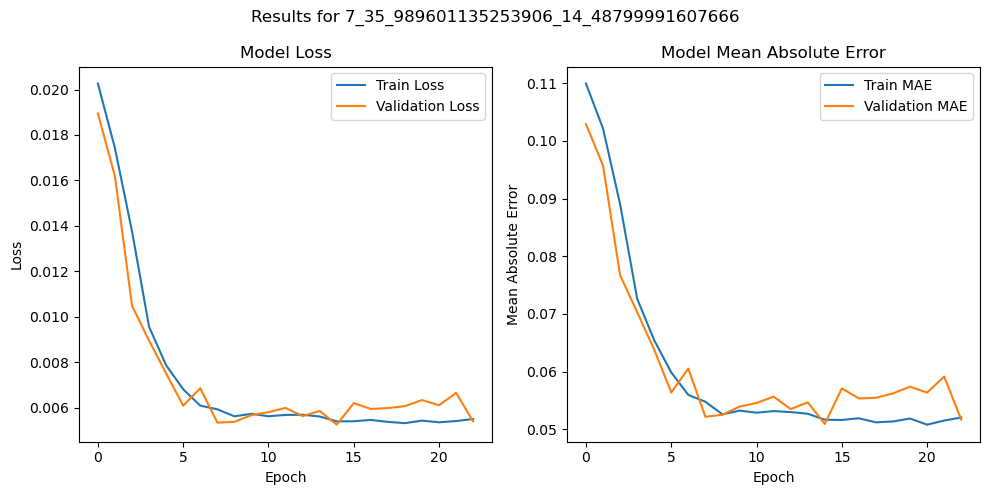

22/22 [==============================] - 11s 431ms/step

Test set Evaluation metrics for file: 7_35_989601135253906_14_48799991607666
Mean Squared Error (MSE): 0.00395524822659379
Mean Absolute Error (MAE): 0.0486965822671294
Root Mean Squared Error (RMSE): 0.06289076423922507



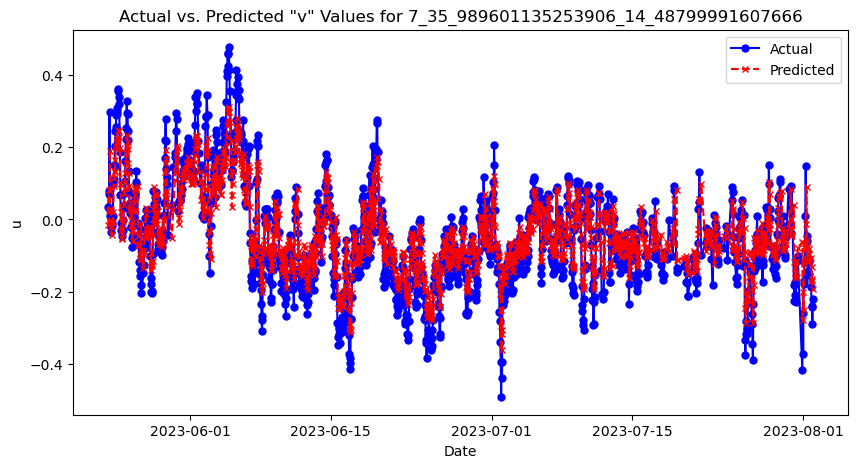

Model tarining & evaluation completed for file: 7_35_989601135253906_14_48799991607666.csv

Processing file: 8_35_989601135253906_14_528599739074707.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.1023INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 178s 1s/step - loss: 0.0179 - mean_absolute_error: 0.1023 - val_loss: 0.0180 - val_mean_absolute_error: 0.0974
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0918INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 166s 1s/step - loss: 0.0147 - mean_absolute_error: 0.0918 - val_loss: 0.0163 - val_mean_absolute_error: 0.0909
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0785INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 182s 2s/step - loss: 0.0115 - mean_absolute_error: 0.0785 - val_loss: 0.0119 - val_mean_absolute_error: 0.0702
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0667INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 178s 2s/step - loss: 0.0090 - mean_absolute_error: 0.0667 - val_loss: 0.0111 - val_mean_absolute_error: 0.0669
Epoch 5/100
117/117 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0590INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 180s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0590 - val_loss: 0.0097 - val_mean_absolute_error: 0.0582
Epoch 6/100
117/117 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0547INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 182s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0547 - val_loss: 0.0094 - val_mean_absolute_error: 0.0562
Epoch 7/100
117/117 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0518INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 184s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0518 - val_loss: 0.0094 - val_mean_absolute_error: 0.0554
Epoch 8/100
117/117 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0507INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 169s 1s/step - loss: 0.0062 - mean_absolute_error: 0.0507 - val_loss: 0.0092 - val_mean_absolute_error: 0.0536
Epoch 9/100
117/117 [==============================] - 156s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0501 - val_loss: 0.0093 - val_mean_absolute_error: 0.0551
Epoch 10/100
117/117 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0503INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 166s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0503 - val_loss: 0.0089 - val_mean_absolute_error: 0.0517
Epoch 11/100
117/117 [==============================] - 156s 1s/step - loss: 0.0057 - mean_absolute_error: 0.0483 - val_loss: 0.0093 - val_mean_absolute_error: 0.0556
Epoch 12/100
117/117 [==============================] - 156s 1s/step - loss: 0.0058 - mean_absolute_error: 0.0486 - val_loss: 0.0090 - val_mean_absolute_error: 0.0530
Epoch 13/100
117/117 [==============================] - 155s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0472 - val_loss: 0.0089 - val_mean_absolute_error: 0.0530
Epoch 14/100
117/117 [==============================] - 155s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0481 - val_loss: 0.0090 - val_mean_absolute_error: 0.0553
Epoch 15/100
117/117 [==============================] - 155s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0477 - val_loss: 0.0090 - val_mean_absolute_error: 0.0534
Epoch 16/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 165s 1s/step - loss: 0.0057 - mean_absolute_error: 0.0480 - val_loss: 0.0088 - val_mean_absolute_error: 0.0549
Epoch 17/100
117/117 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 166s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0087 - val_mean_absolute_error: 0.0539
Epoch 18/100
117/117 [==============================] - 156s 1s/step - loss: 0.0055 - mean_absolute_error: 0.0471 - val_loss: 0.0088 - val_mean_absolute_error: 0.0545
Epoch 19/100
117/117 [==============================] - 156s 1s/step - loss: 0.0055 - mean_absolute_error: 0.0465 - val_loss: 0.0089 - val_mean_absolute_error: 0.0551
Epoch 20/100
117/117 [==============================] - 156s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0461 - val_loss: 0.0088 - val_mean_absolute_error: 0.0553
Epoch 21/100
117/117 [==============================] - 156s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0467 - val_loss: 0.0093 - val_mean_absolute_error: 0.0576
Epoch 22/100
117/117 [==============================] - 156s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0462 - val_loss: 0.0089 - val_mean_absolute_error: 0.0558
Epoch 23/10

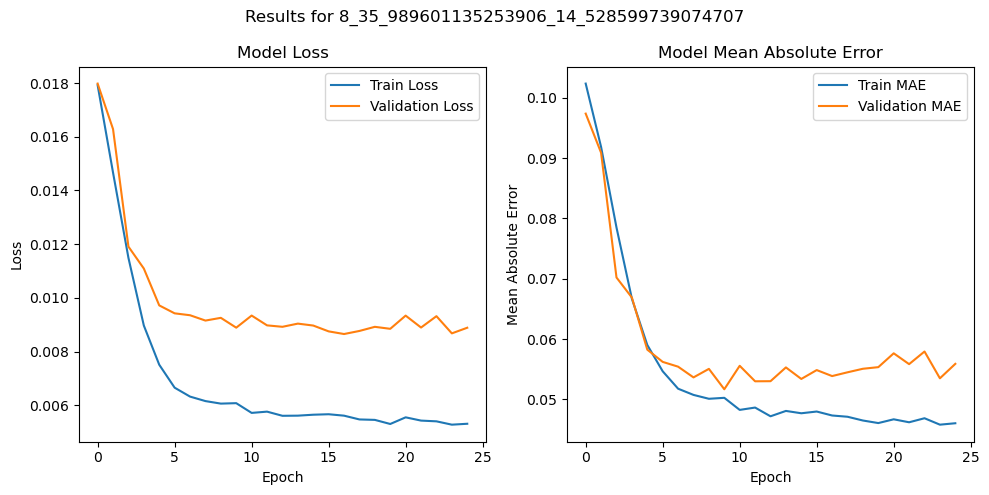

25/25 [==============================] - 12s 440ms/step

Test set Evaluation metrics for file: 8_35_989601135253906_14_528599739074707
Mean Squared Error (MSE): 0.003211450133031504
Mean Absolute Error (MAE): 0.044605034730050494
Root Mean Squared Error (RMSE): 0.05666965795760112



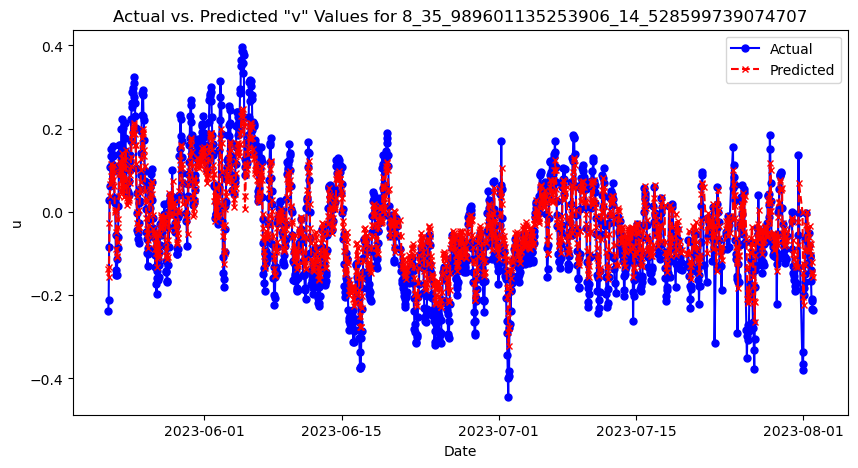

Model tarining & evaluation completed for file: 8_35_989601135253906_14_528599739074707.csv

Processing file: 9_35_989601135253906_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0992INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 187s 2s/step - loss: 0.0166 - mean_absolute_error: 0.0992 - val_loss: 0.0158 - val_mean_absolute_error: 0.0933
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0862INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 177s 2s/step - loss: 0.0130 - mean_absolute_error: 0.0862 - val_loss: 0.0122 - val_mean_absolute_error: 0.0759
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0699INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 176s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0699 - val_loss: 0.0102 - val_mean_absolute_error: 0.0653
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0597INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 173s 1s/step - loss: 0.0076 - mean_absolute_error: 0.0597 - val_loss: 0.0088 - val_mean_absolute_error: 0.0570
Epoch 5/100
117/117 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0533INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 192s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0533 - val_loss: 0.0084 - val_mean_absolute_error: 0.0549
Epoch 6/100
117/117 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 193s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0081 - val_mean_absolute_error: 0.0533
Epoch 7/100
117/117 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0486INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 195s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0486 - val_loss: 0.0077 - val_mean_absolute_error: 0.0500
Epoch 8/100
117/117 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 196s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0077 - val_mean_absolute_error: 0.0496
Epoch 9/100
117/117 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0469INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 196s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0469 - val_loss: 0.0076 - val_mean_absolute_error: 0.0500
Epoch 10/100
117/117 [==============================] - 179s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0458 - val_loss: 0.0078 - val_mean_absolute_error: 0.0512
Epoch 11/100
117/117 [==============================] - 172s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0463 - val_loss: 0.0078 - val_mean_absolute_error: 0.0520
Epoch 12/100
117/117 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0460INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 181s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0460 - val_loss: 0.0073 - val_mean_absolute_error: 0.0486
Epoch 13/100
117/117 [==============================] - 171s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0459 - val_loss: 0.0075 - val_mean_absolute_error: 0.0511
Epoch 14/100
117/117 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0450INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 180s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0450 - val_loss: 0.0072 - val_mean_absolute_error: 0.0483
Epoch 15/100
117/117 [==============================] - 168s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0450 - val_loss: 0.0074 - val_mean_absolute_error: 0.0508
Epoch 16/100
117/117 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0439INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 178s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0439 - val_loss: 0.0071 - val_mean_absolute_error: 0.0485
Epoch 17/100
117/117 [==============================] - 168s 1s/step - loss: 0.0050 - mean_absolute_error: 0.0434 - val_loss: 0.0071 - val_mean_absolute_error: 0.0486
Epoch 18/100
117/117 [==============================] - 168s 1s/step - loss: 0.0050 - mean_absolute_error: 0.0437 - val_loss: 0.0073 - val_mean_absolute_error: 0.0496
Epoch 19/100
117/117 [==============================] - 171s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0436 - val_loss: 0.0071 - val_mean_absolute_error: 0.0480
Epoch 20/100
117/117 [==============================] - 167s 1s/step - loss: 0.0050 - mean_absolute_error: 0.0437 - val_loss: 0.0073 - val_mean_absolute_error: 0.0498
Epoch 21/100
117/117 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0430INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_3

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 179s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0430 - val_loss: 0.0069 - val_mean_absolute_error: 0.0463
Epoch 22/100
117/117 [==============================] - 172s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0431 - val_loss: 0.0076 - val_mean_absolute_error: 0.0504
Epoch 23/100
117/117 [==============================] - 172s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0430 - val_loss: 0.0072 - val_mean_absolute_error: 0.0479
Epoch 24/100
117/117 [==============================] - 172s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0423 - val_loss: 0.0070 - val_mean_absolute_error: 0.0477
Epoch 25/100
117/117 [==============================] - 172s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0429 - val_loss: 0.0074 - val_mean_absolute_error: 0.0508
Epoch 26/100
117/117 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0422INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_3

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 182s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0422 - val_loss: 0.0069 - val_mean_absolute_error: 0.0468
Epoch 27/100
117/117 [==============================] - 171s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0424 - val_loss: 0.0071 - val_mean_absolute_error: 0.0477
Epoch 28/100
117/117 [==============================] - 171s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0425 - val_loss: 0.0077 - val_mean_absolute_error: 0.0508
Epoch 29/100
117/117 [==============================] - 171s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0424 - val_loss: 0.0076 - val_mean_absolute_error: 0.0512
Epoch 30/100
117/117 [==============================] - 171s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0425 - val_loss: 0.0076 - val_mean_absolute_error: 0.0510
Epoch 31/100
117/117 [==============================] - 171s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0419 - val_loss: 0.0074 - val_mean_absolute_error: 0.0508
Epoch 32/10

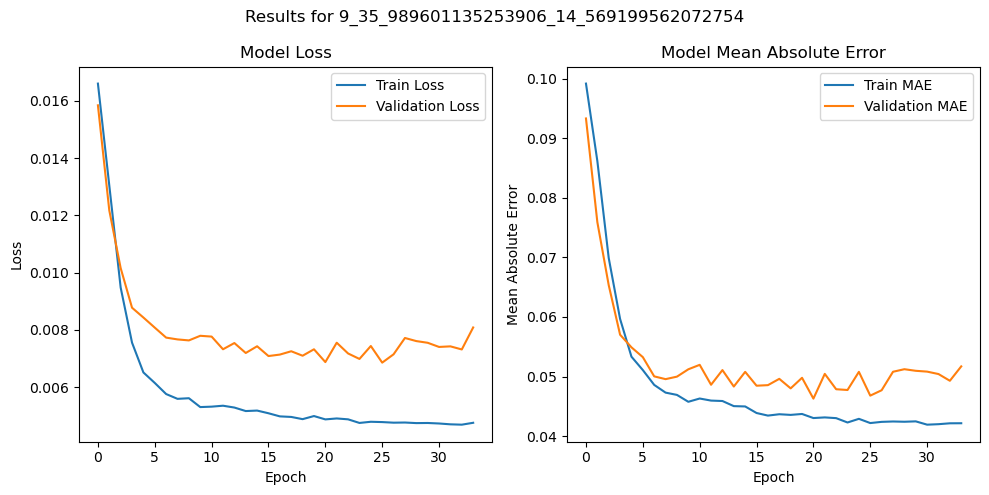

25/25 [==============================] - 13s 468ms/step

Test set Evaluation metrics for file: 9_35_989601135253906_14_569199562072754
Mean Squared Error (MSE): 0.0023783248359447056
Mean Absolute Error (MAE): 0.03691690278409556
Root Mean Squared Error (RMSE): 0.0487680718907843



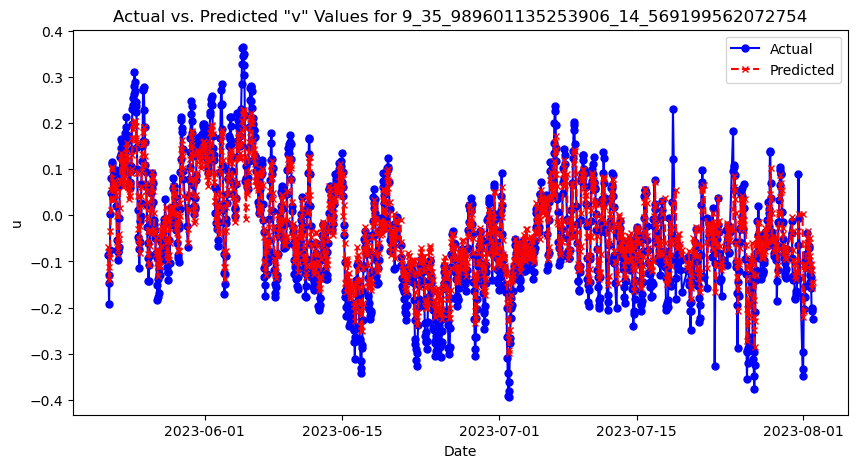

Model tarining & evaluation completed for file: 9_35_989601135253906_14_569199562072754.csv

Processing file: 10_36_01190185546875_14_447500228881836.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.1096INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 163s 2s/step - loss: 0.0201 - mean_absolute_error: 0.1096 - val_loss: 0.0122 - val_mean_absolute_error: 0.0869
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0991INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 165s 2s/step - loss: 0.0167 - mean_absolute_error: 0.0991 - val_loss: 0.0115 - val_mean_absolute_error: 0.0850
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0888INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 177s 2s/step - loss: 0.0137 - mean_absolute_error: 0.0888 - val_loss: 0.0084 - val_mean_absolute_error: 0.0699
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0754INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 178s 2s/step - loss: 0.0103 - mean_absolute_error: 0.0754 - val_loss: 0.0067 - val_mean_absolute_error: 0.0610
Epoch 5/100
102/102 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0680INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 178s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0680 - val_loss: 0.0058 - val_mean_absolute_error: 0.0563
Epoch 6/100
102/102 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0629INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 179s 2s/step - loss: 0.0077 - mean_absolute_error: 0.0629 - val_loss: 0.0057 - val_mean_absolute_error: 0.0562
Epoch 7/100
102/102 [==============================] - 168s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0601 - val_loss: 0.0059 - val_mean_absolute_error: 0.0584
Epoch 8/100
102/102 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0599INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 179s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0599 - val_loss: 0.0054 - val_mean_absolute_error: 0.0542
Epoch 9/100
102/102 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0588INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 178s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0588 - val_loss: 0.0051 - val_mean_absolute_error: 0.0522
Epoch 10/100
102/102 [==============================] - 167s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0586 - val_loss: 0.0053 - val_mean_absolute_error: 0.0535
Epoch 11/100
102/102 [==============================] - 174s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0592 - val_loss: 0.0052 - val_mean_absolute_error: 0.0532
Epoch 12/100
102/102 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0588INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 178s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0588 - val_loss: 0.0050 - val_mean_absolute_error: 0.0510
Epoch 13/100
102/102 [==============================] - 169s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0586 - val_loss: 0.0050 - val_mean_absolute_error: 0.0510
Epoch 14/100
102/102 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0578INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 179s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0578 - val_loss: 0.0047 - val_mean_absolute_error: 0.0490
Epoch 15/100
102/102 [==============================] - 168s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0577 - val_loss: 0.0051 - val_mean_absolute_error: 0.0522
Epoch 16/100
102/102 [==============================] - 169s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0581 - val_loss: 0.0049 - val_mean_absolute_error: 0.0504
Epoch 17/100
102/102 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0572INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 180s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0572 - val_loss: 0.0046 - val_mean_absolute_error: 0.0481
Epoch 18/100
102/102 [==============================] - 170s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0580 - val_loss: 0.0047 - val_mean_absolute_error: 0.0490
Epoch 19/100
102/102 [==============================] - 169s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0585 - val_loss: 0.0051 - val_mean_absolute_error: 0.0521
Epoch 20/100
102/102 [==============================] - 169s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0579 - val_loss: 0.0048 - val_mean_absolute_error: 0.0495
Epoch 21/100
102/102 [==============================] - 170s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0563 - val_loss: 0.0050 - val_mean_absolute_error: 0.0514
Epoch 22/100
102/102 [==============================] - 169s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0574 - val_loss: 0.0050 - val_mean_absolute_error: 0.0512
Epoch 23/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 179s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0565 - val_loss: 0.0045 - val_mean_absolute_error: 0.0471
Epoch 24/100
102/102 [==============================] - 170s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0574 - val_loss: 0.0048 - val_mean_absolute_error: 0.0502
Epoch 25/100
102/102 [==============================] - 167s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0561 - val_loss: 0.0047 - val_mean_absolute_error: 0.0489
Epoch 26/100
102/102 [==============================] - 168s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0562 - val_loss: 0.0046 - val_mean_absolute_error: 0.0480
Epoch 27/100
102/102 [==============================] - 168s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0574 - val_loss: 0.0050 - val_mean_absolute_error: 0.0510
Epoch 28/100
102/102 [==============================] - 168s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0568 - val_loss: 0.0050 - val_mean_absolute_error: 0.0515
Epoch 29/10

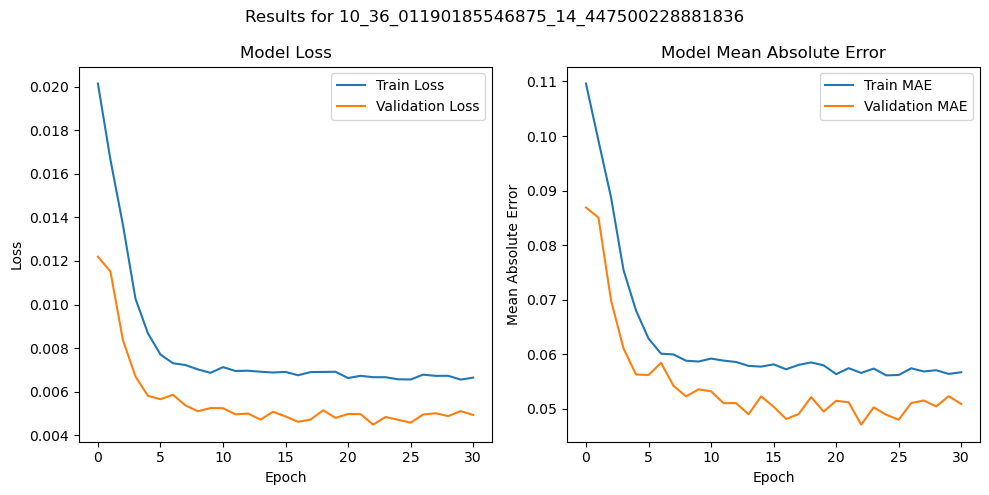

21/21 [==============================] - 13s 555ms/step

Test set Evaluation metrics for file: 10_36_01190185546875_14_447500228881836
Mean Squared Error (MSE): 0.004553097147128359
Mean Absolute Error (MAE): 0.04814056394874884
Root Mean Squared Error (RMSE): 0.0674766414926555



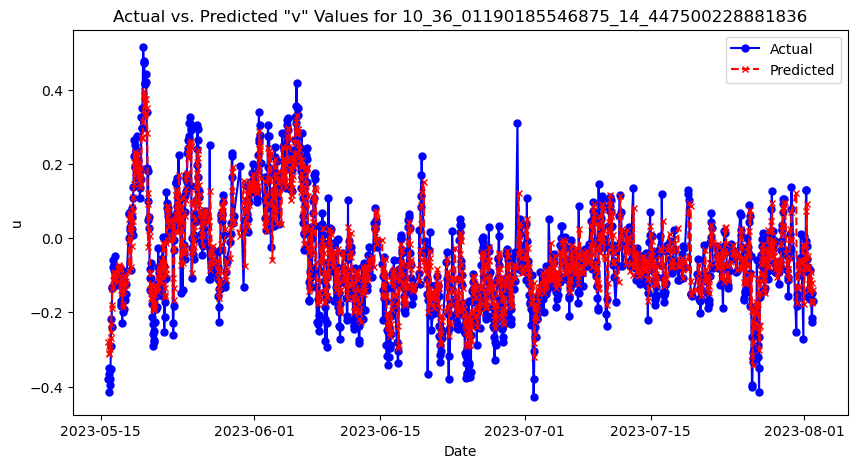

Model tarining & evaluation completed for file: 10_36_01190185546875_14_447500228881836.csv

Processing file: 11_36_01190185546875_14_48799991607666.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.1045INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 214s 2s/step - loss: 0.0186 - mean_absolute_error: 0.1045 - val_loss: 0.0125 - val_mean_absolute_error: 0.0852
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0885INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 210s 2s/step - loss: 0.0136 - mean_absolute_error: 0.0885 - val_loss: 0.0084 - val_mean_absolute_error: 0.0694
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0715INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 208s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0715 - val_loss: 0.0059 - val_mean_absolute_error: 0.0579
Epoch 4/100
121/121 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0607INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 210s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0607 - val_loss: 0.0048 - val_mean_absolute_error: 0.0514
Epoch 5/100
121/121 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0557INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 217s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0557 - val_loss: 0.0046 - val_mean_absolute_error: 0.0504
Epoch 6/100
121/121 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0539INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 209s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0539 - val_loss: 0.0040 - val_mean_absolute_error: 0.0468
Epoch 7/100
121/121 [==============================] - 198s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0507 - val_loss: 0.0042 - val_mean_absolute_error: 0.0483
Epoch 8/100
121/121 [==============================] - 198s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0513 - val_loss: 0.0041 - val_mean_absolute_error: 0.0478
Epoch 9/100
121/121 [==============================] - 198s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0498 - val_loss: 0.0042 - val_mean_absolute_error: 0.0483
Epoch 10/100
121/121 [==============================] - 198s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0490 - val_loss: 0.0042 - val_mean_absolute_error: 0.0477
Epoch 11/100
121/121 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0488INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 207s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0488 - val_loss: 0.0039 - val_mean_absolute_error: 0.0454
Epoch 12/100
121/121 [==============================] - 197s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0492 - val_loss: 0.0041 - val_mean_absolute_error: 0.0469
Epoch 13/100
121/121 [==============================] - 197s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0501 - val_loss: 0.0040 - val_mean_absolute_error: 0.0467
Epoch 14/100
121/121 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0496INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 207s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0496 - val_loss: 0.0038 - val_mean_absolute_error: 0.0451
Epoch 15/100
121/121 [==============================] - 218s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0492 - val_loss: 0.0042 - val_mean_absolute_error: 0.0479
Epoch 16/100
121/121 [==============================] - 220s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0491 - val_loss: 0.0039 - val_mean_absolute_error: 0.0458
Epoch 17/100
121/121 [==============================] - 217s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0485 - val_loss: 0.0040 - val_mean_absolute_error: 0.0467
Epoch 18/100
121/121 [==============================] - 219s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0487 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448
Epoch 19/100
121/121 [==============================] - 218s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0487 - val_loss: 0.0039 - val_mean_absolute_error: 0.0458
Epoch 20/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 229s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0485 - val_loss: 0.0037 - val_mean_absolute_error: 0.0441
Epoch 22/100
121/121 [==============================] - 233s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457
Epoch 23/100
121/121 [==============================] - 233s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0481 - val_loss: 0.0040 - val_mean_absolute_error: 0.0465
Epoch 24/100
121/121 [==============================] - 232s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0480 - val_loss: 0.0040 - val_mean_absolute_error: 0.0464
Epoch 25/100
121/121 [==============================] - 232s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0466 - val_loss: 0.0040 - val_mean_absolute_error: 0.0461
Epoch 26/100
121/121 [==============================] - 233s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0471 - val_loss: 0.0039 - val_mean_absolute_error: 0.0460
Epoch 27/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 243s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0475 - val_loss: 0.0035 - val_mean_absolute_error: 0.0428
Epoch 29/100
121/121 [==============================] - 232s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0468 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469
Epoch 30/100
121/121 [==============================] - 232s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0471 - val_loss: 0.0043 - val_mean_absolute_error: 0.0483
Epoch 31/100
121/121 [==============================] - 231s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0466 - val_loss: 0.0038 - val_mean_absolute_error: 0.0455
Epoch 32/100
121/121 [==============================] - 232s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0467 - val_loss: 0.0041 - val_mean_absolute_error: 0.0475
Epoch 33/100
121/121 [==============================] - 231s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0469 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448
Epoch 34/10

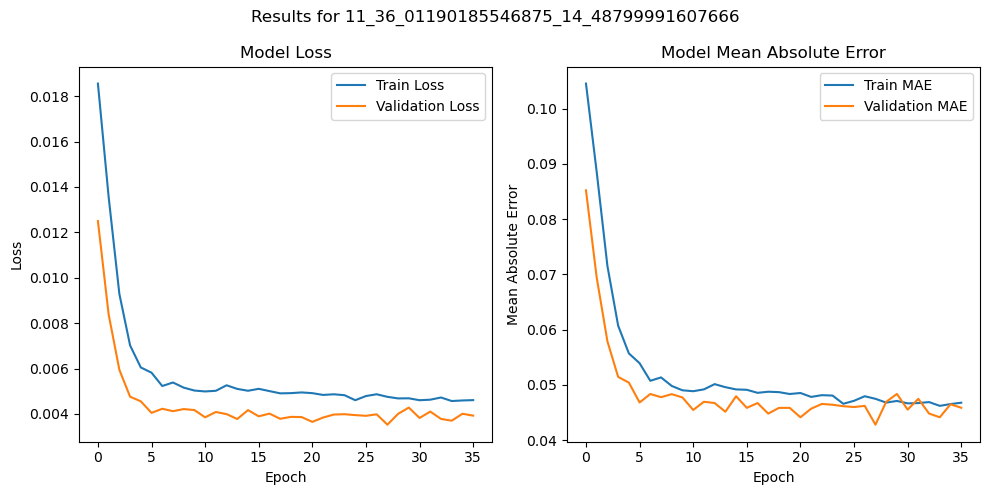

26/26 [==============================] - 17s 596ms/step

Test set Evaluation metrics for file: 11_36_01190185546875_14_48799991607666
Mean Squared Error (MSE): 0.0029727148817995184
Mean Absolute Error (MAE): 0.04129230231875212
Root Mean Squared Error (RMSE): 0.05452260890492602



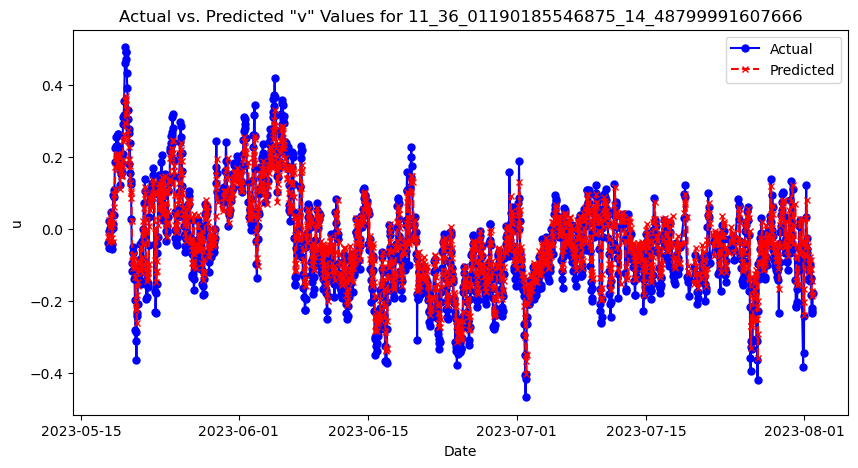

Model tarining & evaluation completed for file: 11_36_01190185546875_14_48799991607666.csv

Processing file: 12_36_01190185546875_14_528599739074707.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
135/135 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.1016INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 272s 2s/step - loss: 0.0179 - mean_absolute_error: 0.1016 - val_loss: 0.0145 - val_mean_absolute_error: 0.0851
Epoch 2/100
135/135 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0891INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 267s 2s/step - loss: 0.0140 - mean_absolute_error: 0.0891 - val_loss: 0.0108 - val_mean_absolute_error: 0.0676
Epoch 3/100
135/135 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0707INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 264s 2s/step - loss: 0.0097 - mean_absolute_error: 0.0707 - val_loss: 0.0088 - val_mean_absolute_error: 0.0579
Epoch 4/100
135/135 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0595INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 264s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0595 - val_loss: 0.0080 - val_mean_absolute_error: 0.0525
Epoch 5/100
135/135 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0548INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 265s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0548 - val_loss: 0.0077 - val_mean_absolute_error: 0.0500
Epoch 6/100
135/135 [==============================] - 253s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0526 - val_loss: 0.0078 - val_mean_absolute_error: 0.0498
Epoch 7/100
135/135 [==============================] - 253s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0524 - val_loss: 0.0078 - val_mean_absolute_error: 0.0501
Epoch 8/100
135/135 [==============================] - 254s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0526 - val_loss: 0.0080 - val_mean_absolute_error: 0.0518
Epoch 9/100
135/135 [==============================] - 253s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0520 - val_loss: 0.0078 - val_mean_absolute_error: 0.0500
Epoch 10/100
135/135 [==============================] - 253s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0503 - val_loss: 0.0078 - val_mean_absolute_error: 0.0504
Epoch 11/100
13

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 265s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0508 - val_loss: 0.0076 - val_mean_absolute_error: 0.0489
Epoch 13/100
135/135 [==============================] - 255s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0497 - val_loss: 0.0077 - val_mean_absolute_error: 0.0493
Epoch 14/100
135/135 [==============================] - 255s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0495 - val_loss: 0.0076 - val_mean_absolute_error: 0.0498
Epoch 15/100
135/135 [==============================] - 255s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0497 - val_loss: 0.0076 - val_mean_absolute_error: 0.0502
Epoch 16/100
135/135 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0491INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 264s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0491 - val_loss: 0.0074 - val_mean_absolute_error: 0.0480
Epoch 17/100
135/135 [==============================] - 254s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0495 - val_loss: 0.0077 - val_mean_absolute_error: 0.0511
Epoch 18/100
135/135 [==============================] - 253s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0488 - val_loss: 0.0076 - val_mean_absolute_error: 0.0502
Epoch 19/100
135/135 [==============================] - 254s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0486 - val_loss: 0.0074 - val_mean_absolute_error: 0.0486
Epoch 20/100
135/135 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0477INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 264s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0477 - val_loss: 0.0074 - val_mean_absolute_error: 0.0483
Epoch 21/100
135/135 [==============================] - 255s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0483 - val_loss: 0.0077 - val_mean_absolute_error: 0.0509
Epoch 22/100
135/135 [==============================] - 255s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0476 - val_loss: 0.0074 - val_mean_absolute_error: 0.0485
Epoch 23/100
135/135 [==============================] - 255s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0483 - val_loss: 0.0074 - val_mean_absolute_error: 0.0489
Epoch 24/100
135/135 [==============================] - 255s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0479 - val_loss: 0.0074 - val_mean_absolute_error: 0.0480
Epoch 25/100
135/135 [==============================] - 255s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0075 - val_mean_absolute_error: 0.0492
Epoch 26/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 265s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0485 - val_loss: 0.0073 - val_mean_absolute_error: 0.0477
Epoch 27/100
135/135 [==============================] - 253s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0481 - val_loss: 0.0075 - val_mean_absolute_error: 0.0493
Epoch 28/100
135/135 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 265s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0072 - val_mean_absolute_error: 0.0474
Epoch 29/100
135/135 [==============================] - 255s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0475 - val_loss: 0.0076 - val_mean_absolute_error: 0.0501
Epoch 30/100
135/135 [==============================] - 255s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0478 - val_loss: 0.0079 - val_mean_absolute_error: 0.0523
Epoch 31/100
135/135 [==============================] - 255s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0472 - val_loss: 0.0075 - val_mean_absolute_error: 0.0487
Epoch 32/100
135/135 [==============================] - 254s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0475 - val_loss: 0.0073 - val_mean_absolute_error: 0.0477
Epoch 33/100
135/135 [==============================] - 255s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0469 - val_loss: 0.0073 - val_mean_absolute_error: 0.0480
Epoch 34/10

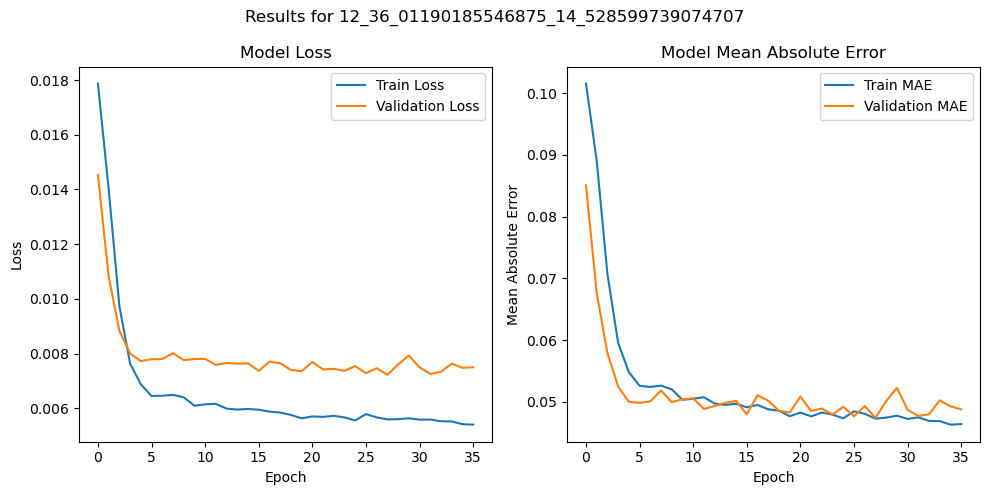

28/28 [==============================] - 19s 612ms/step

Test set Evaluation metrics for file: 12_36_01190185546875_14_528599739074707
Mean Squared Error (MSE): 0.0023662068104051844
Mean Absolute Error (MAE): 0.03630001548388994
Root Mean Squared Error (RMSE): 0.04864367184336709



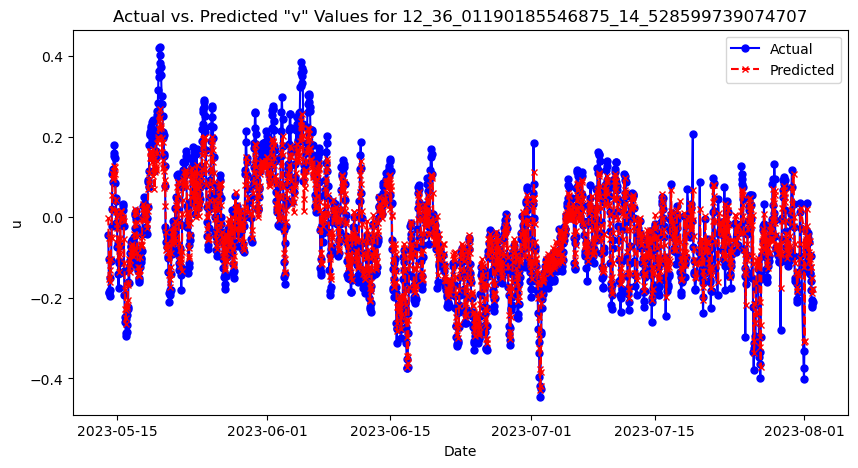

Model tarining & evaluation completed for file: 12_36_01190185546875_14_528599739074707.csv

Processing file: 13_36_01190185546875_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0969INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 265s 2s/step - loss: 0.0160 - mean_absolute_error: 0.0969 - val_loss: 0.0115 - val_mean_absolute_error: 0.0771
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0849INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 285s 2s/step - loss: 0.0127 - mean_absolute_error: 0.0849 - val_loss: 0.0096 - val_mean_absolute_error: 0.0656
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0696INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 283s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0696 - val_loss: 0.0073 - val_mean_absolute_error: 0.0536
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0586INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 284s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0586 - val_loss: 0.0068 - val_mean_absolute_error: 0.0497
Epoch 5/100
133/133 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0535INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 283s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0535 - val_loss: 0.0062 - val_mean_absolute_error: 0.0445
Epoch 6/100
133/133 [==============================] - 272s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0503 - val_loss: 0.0063 - val_mean_absolute_error: 0.0456
Epoch 7/100
133/133 [==============================] - 272s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0500 - val_loss: 0.0063 - val_mean_absolute_error: 0.0456
Epoch 8/100
133/133 [==============================] - 273s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0489 - val_loss: 0.0062 - val_mean_absolute_error: 0.0451
Epoch 9/100
133/133 [==============================] - 272s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0487 - val_loss: 0.0063 - val_mean_absolute_error: 0.0450
Epoch 10/100
133/133 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_0

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 284s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0478 - val_loss: 0.0061 - val_mean_absolute_error: 0.0452
Epoch 11/100
133/133 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0484INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 283s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0484 - val_loss: 0.0059 - val_mean_absolute_error: 0.0434
Epoch 12/100
133/133 [==============================] - 272s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0468 - val_loss: 0.0061 - val_mean_absolute_error: 0.0447
Epoch 13/100
133/133 [==============================] - 272s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0467 - val_loss: 0.0061 - val_mean_absolute_error: 0.0448
Epoch 14/100
133/133 [==============================] - 273s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0466 - val_loss: 0.0060 - val_mean_absolute_error: 0.0453
Epoch 15/100
133/133 [==============================] - 274s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0061 - val_mean_absolute_error: 0.0449
Epoch 16/100
133/133 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 284s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0464 - val_loss: 0.0057 - val_mean_absolute_error: 0.0430
Epoch 17/100
133/133 [==============================] - 275s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0447 - val_loss: 0.0058 - val_mean_absolute_error: 0.0433
Epoch 18/100
133/133 [==============================] - 430s 3s/step - loss: 0.0052 - mean_absolute_error: 0.0459 - val_loss: 0.0062 - val_mean_absolute_error: 0.0460
Epoch 19/100
133/133 [==============================] - 491s 4s/step - loss: 0.0052 - mean_absolute_error: 0.0462 - val_loss: 0.0060 - val_mean_absolute_error: 0.0455
Epoch 20/100
133/133 [==============================] - 339s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0457 - val_loss: 0.0059 - val_mean_absolute_error: 0.0433
Epoch 21/100
133/133 [==============================] - 275s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0451 - val_loss: 0.0060 - val_mean_absolute_error: 0.0448
Epoch 22/10

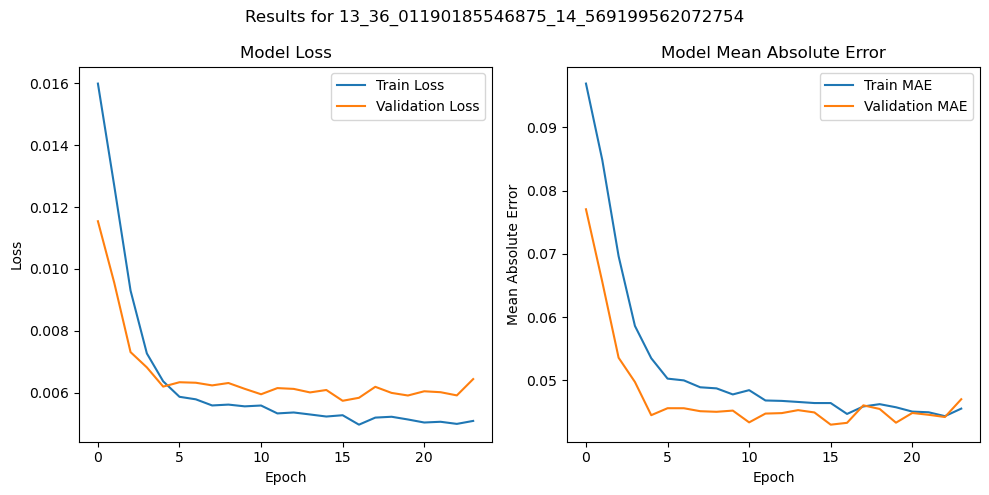

28/28 [==============================] - 20s 670ms/step

Test set Evaluation metrics for file: 13_36_01190185546875_14_569199562072754
Mean Squared Error (MSE): 0.002093701088384485
Mean Absolute Error (MAE): 0.03390882889337011
Root Mean Squared Error (RMSE): 0.04575697857578104



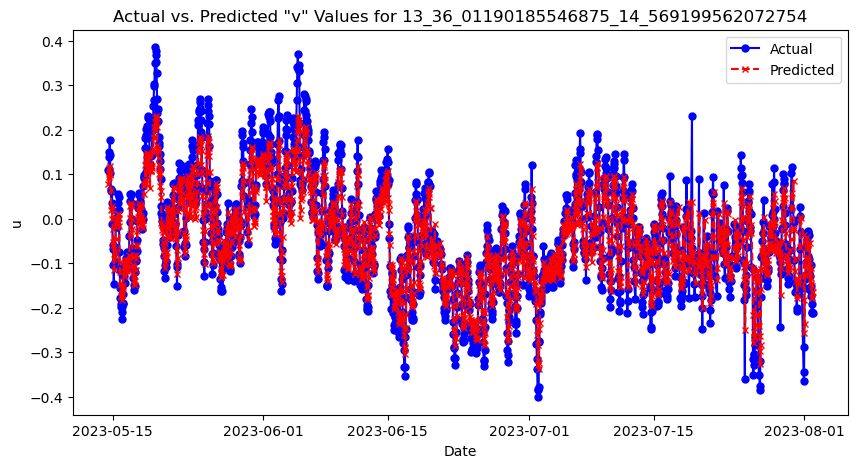

Model tarining & evaluation completed for file: 13_36_01190185546875_14_569199562072754.csv

Processing file: 14_36_03409957885742_14_447500228881836.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.0996INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 274s 2s/step - loss: 0.0169 - mean_absolute_error: 0.0996 - val_loss: 0.0087 - val_mean_absolute_error: 0.0743
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0835INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 269s 2s/step - loss: 0.0123 - mean_absolute_error: 0.0835 - val_loss: 0.0080 - val_mean_absolute_error: 0.0720
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0682INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 266s 2s/step - loss: 0.0086 - mean_absolute_error: 0.0682 - val_loss: 0.0065 - val_mean_absolute_error: 0.0649
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0603INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 270s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0603 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 5/100
125/125 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0551INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 268s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0551 - val_loss: 0.0040 - val_mean_absolute_error: 0.0484
Epoch 6/100
125/125 [==============================] - 255s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0537 - val_loss: 0.0041 - val_mean_absolute_error: 0.0493
Epoch 7/100
125/125 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0527INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 267s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0527 - val_loss: 0.0037 - val_mean_absolute_error: 0.0468
Epoch 8/100
125/125 [==============================] - 257s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0519 - val_loss: 0.0038 - val_mean_absolute_error: 0.0470
Epoch 9/100
125/125 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 267s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0516 - val_loss: 0.0030 - val_mean_absolute_error: 0.0410
Epoch 10/100
125/125 [==============================] - 255s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0517 - val_loss: 0.0033 - val_mean_absolute_error: 0.0431
Epoch 11/100
125/125 [==============================] - 256s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0513 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410
Epoch 12/100
125/125 [==============================] - 256s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0513 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410
Epoch 13/100
125/125 [==============================] - 256s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0508 - val_loss: 0.0032 - val_mean_absolute_error: 0.0420
Epoch 14/100
125/125 [==============================] - 256s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0507 - val_loss: 0.0033 - val_mean_absolute_error: 0.0431
Epoch 15/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 266s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0030 - val_mean_absolute_error: 0.0404
Epoch 17/100
125/125 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0506INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 273s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0506 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397
Epoch 18/100
125/125 [==============================] - 256s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0031 - val_mean_absolute_error: 0.0415
Epoch 19/100
125/125 [==============================] - 255s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411
Epoch 20/100
125/125 [==============================] - 255s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0490 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400
Epoch 21/100
125/125 [==============================] - 256s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0502 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405
Epoch 22/100
125/125 [==============================] - 255s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0493 - val_loss: 0.0030 - val_mean_absolute_error: 0.0407
Epoch 23/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 265s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0506 - val_loss: 0.0029 - val_mean_absolute_error: 0.0390
Epoch 24/100
125/125 [==============================] - 266s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394
Epoch 25/100
125/125 [==============================] - 261s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0492 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400
Epoch 26/100
125/125 [==============================] - 251s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0491 - val_loss: 0.0029 - val_mean_absolute_error: 0.0398
Epoch 27/100
125/125 [==============================] - 254s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0498 - val_loss: 0.0030 - val_mean_absolute_error: 0.0399
Epoch 28/100
125/125 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0496INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 266s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0028 - val_mean_absolute_error: 0.0384
Epoch 29/100
125/125 [==============================] - 253s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0486 - val_loss: 0.0028 - val_mean_absolute_error: 0.0386
Epoch 30/100
125/125 [==============================] - 253s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0489 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395
Epoch 31/100
125/125 [==============================] - 253s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0492 - val_loss: 0.0029 - val_mean_absolute_error: 0.0393
Epoch 32/100
125/125 [==============================] - 254s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0491 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411
Epoch 33/100
125/125 [==============================] - 253s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0490 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394
Epoch 34/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 263s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0485 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380
Epoch 35/100
125/125 [==============================] - 253s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388
Epoch 36/100
125/125 [==============================] - 252s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0488 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388
Epoch 37/100
125/125 [==============================] - 252s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0490 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388
Epoch 38/100
125/125 [==============================] - 252s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394
Epoch 39/100
125/125 [==============================] - 253s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0488 - val_loss: 0.0029 - val_mean_absolute_error: 0.0392
Epoch 40/10

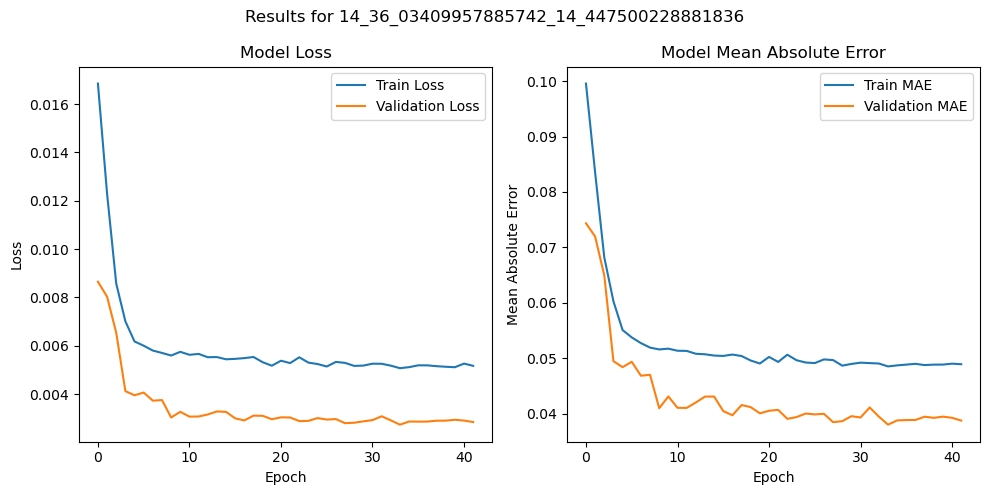

26/26 [==============================] - 21s 747ms/step

Test set Evaluation metrics for file: 14_36_03409957885742_14_447500228881836
Mean Squared Error (MSE): 0.003257434161702893
Mean Absolute Error (MAE): 0.04132411272785601
Root Mean Squared Error (RMSE): 0.057073935922651184



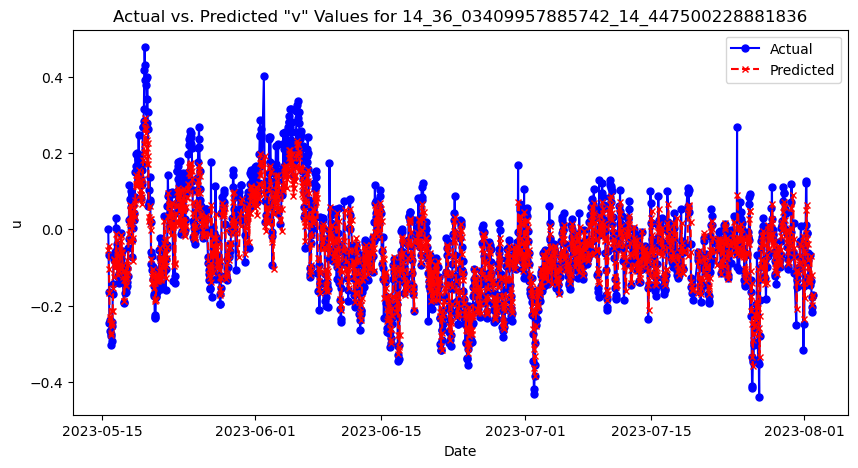

Model tarining & evaluation completed for file: 14_36_03409957885742_14_447500228881836.csv

Processing file: 15_36_03409957885742_14_48799991607666.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0981INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 293s 2s/step - loss: 0.0165 - mean_absolute_error: 0.0981 - val_loss: 0.0119 - val_mean_absolute_error: 0.0865
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0861INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 283s 2s/step - loss: 0.0131 - mean_absolute_error: 0.0861 - val_loss: 0.0096 - val_mean_absolute_error: 0.0771
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0691INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 282s 2s/step - loss: 0.0087 - mean_absolute_error: 0.0691 - val_loss: 0.0068 - val_mean_absolute_error: 0.0645
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0591INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 277s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0591 - val_loss: 0.0050 - val_mean_absolute_error: 0.0535
Epoch 5/100
137/137 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0528INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 275s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0528 - val_loss: 0.0040 - val_mean_absolute_error: 0.0463
Epoch 6/100
137/137 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0507INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 280s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0507 - val_loss: 0.0037 - val_mean_absolute_error: 0.0446
Epoch 7/100
137/137 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0481INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 282s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0481 - val_loss: 0.0037 - val_mean_absolute_error: 0.0447
Epoch 8/100
137/137 [==============================] - 271s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0478 - val_loss: 0.0039 - val_mean_absolute_error: 0.0462
Epoch 9/100
137/137 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0486INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 280s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0037 - val_mean_absolute_error: 0.0443
Epoch 10/100
137/137 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0482INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 280s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0482 - val_loss: 0.0036 - val_mean_absolute_error: 0.0436
Epoch 11/100
137/137 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0476INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 305s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0476 - val_loss: 0.0035 - val_mean_absolute_error: 0.0428
Epoch 12/100
137/137 [==============================] - 281s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0477 - val_loss: 0.0036 - val_mean_absolute_error: 0.0441
Epoch 13/100
137/137 [==============================] - 278s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0477 - val_loss: 0.0036 - val_mean_absolute_error: 0.0441
Epoch 14/100
137/137 [==============================] - 277s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0475 - val_loss: 0.0035 - val_mean_absolute_error: 0.0430
Epoch 15/100
137/137 [==============================] - 278s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0467 - val_loss: 0.0036 - val_mean_absolute_error: 0.0438
Epoch 16/100
137/137 [==============================] - 280s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0467 - val_loss: 0.0036 - val_mean_absolute_error: 0.0443
Epoch 17/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 289s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0475 - val_loss: 0.0032 - val_mean_absolute_error: 0.0410
Epoch 19/100
137/137 [==============================] - 279s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0471 - val_loss: 0.0035 - val_mean_absolute_error: 0.0433
Epoch 20/100
137/137 [==============================] - 285s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0465 - val_loss: 0.0036 - val_mean_absolute_error: 0.0441
Epoch 21/100
137/137 [==============================] - 280s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0469 - val_loss: 0.0038 - val_mean_absolute_error: 0.0460
Epoch 22/100
137/137 [==============================] - 279s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0458 - val_loss: 0.0035 - val_mean_absolute_error: 0.0437
Epoch 23/100
137/137 [==============================] - 278s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0472 - val_loss: 0.0037 - val_mean_absolute_error: 0.0447
Epoch 24/10

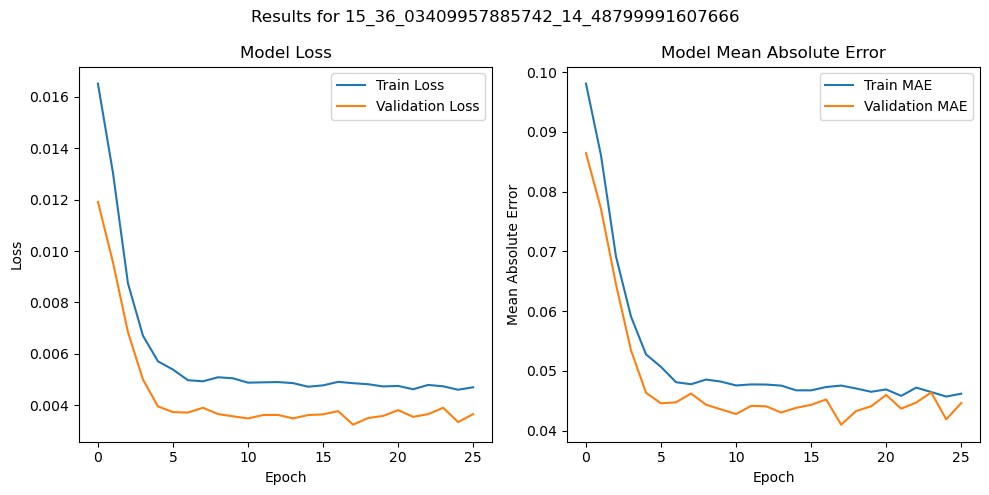

29/29 [==============================] - 23s 750ms/step

Test set Evaluation metrics for file: 15_36_03409957885742_14_48799991607666
Mean Squared Error (MSE): 0.0026873482595502394
Mean Absolute Error (MAE): 0.038302266535567564
Root Mean Squared Error (RMSE): 0.051839639847806034



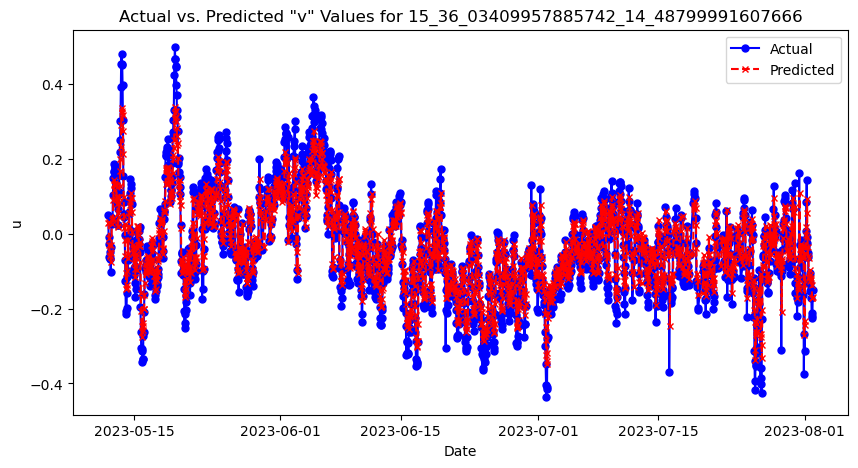

Model tarining & evaluation completed for file: 15_36_03409957885742_14_48799991607666.csv

Processing file: 16_36_03409957885742_14_528599739074707.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0996INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 336s 2s/step - loss: 0.0172 - mean_absolute_error: 0.0996 - val_loss: 0.0132 - val_mean_absolute_error: 0.0837
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0857INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 323s 2s/step - loss: 0.0133 - mean_absolute_error: 0.0857 - val_loss: 0.0093 - val_mean_absolute_error: 0.0634
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0678INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 322s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0678 - val_loss: 0.0081 - val_mean_absolute_error: 0.0568
Epoch 4/100
156/156 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0590INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 321s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0590 - val_loss: 0.0076 - val_mean_absolute_error: 0.0542
Epoch 5/100
156/156 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0553INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 352s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0553 - val_loss: 0.0074 - val_mean_absolute_error: 0.0516
Epoch 6/100
156/156 [==============================] - 333s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0533 - val_loss: 0.0076 - val_mean_absolute_error: 0.0534
Epoch 7/100
156/156 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0533INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 345s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0533 - val_loss: 0.0072 - val_mean_absolute_error: 0.0504
Epoch 8/100
156/156 [==============================] - 332s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0533 - val_loss: 0.0072 - val_mean_absolute_error: 0.0504
Epoch 9/100
156/156 [==============================] - 331s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0522 - val_loss: 0.0073 - val_mean_absolute_error: 0.0512
Epoch 10/100
156/156 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0521INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 341s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0521 - val_loss: 0.0070 - val_mean_absolute_error: 0.0496
Epoch 11/100
156/156 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0519INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 342s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0519 - val_loss: 0.0070 - val_mean_absolute_error: 0.0493
Epoch 12/100
156/156 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 332s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0069 - val_mean_absolute_error: 0.0494
Epoch 13/100
156/156 [==============================] - 314s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0504 - val_loss: 0.0074 - val_mean_absolute_error: 0.0526
Epoch 14/100
156/156 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0505INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 328s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0505 - val_loss: 0.0069 - val_mean_absolute_error: 0.0498
Epoch 15/100
156/156 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0498INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 326s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0498 - val_loss: 0.0068 - val_mean_absolute_error: 0.0490
Epoch 16/100
156/156 [==============================] - 314s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0504 - val_loss: 0.0071 - val_mean_absolute_error: 0.0513
Epoch 17/100
156/156 [==============================] - 314s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0495 - val_loss: 0.0070 - val_mean_absolute_error: 0.0506
Epoch 18/100
156/156 [==============================] - 314s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0500 - val_loss: 0.0074 - val_mean_absolute_error: 0.0534
Epoch 19/100
156/156 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0497INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 324s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0497 - val_loss: 0.0068 - val_mean_absolute_error: 0.0493
Epoch 20/100
156/156 [==============================] - 331s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0502 - val_loss: 0.0070 - val_mean_absolute_error: 0.0512
Epoch 21/100
156/156 [==============================] - 332s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0492 - val_loss: 0.0070 - val_mean_absolute_error: 0.0505
Epoch 22/100
156/156 [==============================] - 331s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0495 - val_loss: 0.0070 - val_mean_absolute_error: 0.0511
Epoch 23/100
156/156 [==============================] - 331s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0492 - val_loss: 0.0069 - val_mean_absolute_error: 0.0503
Epoch 24/100
156/156 [==============================] - 332s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0487 - val_loss: 0.0069 - val_mean_absolute_error: 0.0500
Epoch 25/10

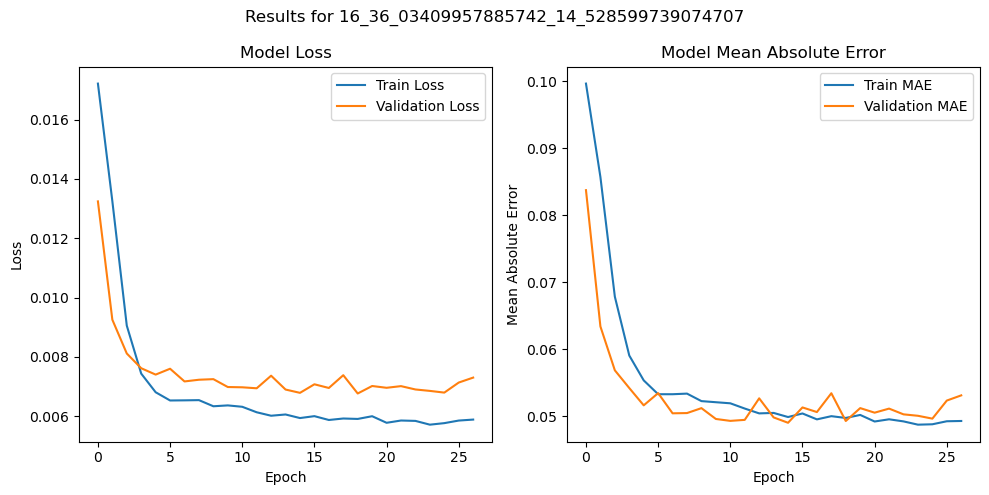

33/33 [==============================] - 27s 775ms/step

Test set Evaluation metrics for file: 16_36_03409957885742_14_528599739074707
Mean Squared Error (MSE): 0.003185930438272277
Mean Absolute Error (MAE): 0.04142322052365889
Root Mean Squared Error (RMSE): 0.05644404696929763



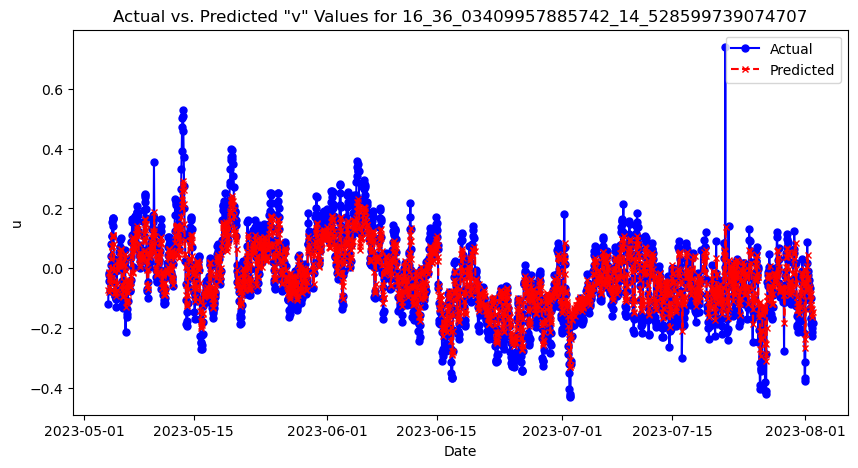

Model tarining & evaluation completed for file: 16_36_03409957885742_14_528599739074707.csv

Processing file: 17_36_03409957885742_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0990INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 350s 2s/step - loss: 0.0166 - mean_absolute_error: 0.0990 - val_loss: 0.0124 - val_mean_absolute_error: 0.0802
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0846INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 331s 2s/step - loss: 0.0127 - mean_absolute_error: 0.0846 - val_loss: 0.0109 - val_mean_absolute_error: 0.0726
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0706INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 328s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0706 - val_loss: 0.0078 - val_mean_absolute_error: 0.0548
Epoch 4/100
153/153 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0603INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 328s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0603 - val_loss: 0.0072 - val_mean_absolute_error: 0.0509
Epoch 5/100
153/153 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0554INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 403s 3s/step - loss: 0.0067 - mean_absolute_error: 0.0554 - val_loss: 0.0068 - val_mean_absolute_error: 0.0484
Epoch 6/100
153/153 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0546INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 403s 3s/step - loss: 0.0066 - mean_absolute_error: 0.0546 - val_loss: 0.0067 - val_mean_absolute_error: 0.0476
Epoch 7/100
153/153 [==============================] - 381s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0527 - val_loss: 0.0067 - val_mean_absolute_error: 0.0477
Epoch 8/100
153/153 [==============================] - 378s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0528 - val_loss: 0.0067 - val_mean_absolute_error: 0.0479
Epoch 9/100
153/153 [==============================] - 379s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0524 - val_loss: 0.0070 - val_mean_absolute_error: 0.0508
Epoch 10/100
153/153 [==============================] - 370s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0517 - val_loss: 0.0068 - val_mean_absolute_error: 0.0495
Epoch 11/100
153/153 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0512INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 384s 3s/step - loss: 0.0061 - mean_absolute_error: 0.0512 - val_loss: 0.0066 - val_mean_absolute_error: 0.0481
Epoch 12/100
153/153 [==============================] - 372s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0068 - val_mean_absolute_error: 0.0500
Epoch 13/100
153/153 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0503INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 383s 3s/step - loss: 0.0060 - mean_absolute_error: 0.0503 - val_loss: 0.0064 - val_mean_absolute_error: 0.0468
Epoch 14/100
153/153 [==============================] - 360s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0497 - val_loss: 0.0064 - val_mean_absolute_error: 0.0468
Epoch 15/100
153/153 [==============================] - 355s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0493 - val_loss: 0.0065 - val_mean_absolute_error: 0.0478
Epoch 16/100
153/153 [==============================] - 356s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0493 - val_loss: 0.0064 - val_mean_absolute_error: 0.0470
Epoch 17/100
153/153 [==============================] - 354s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0492 - val_loss: 0.0066 - val_mean_absolute_error: 0.0487
Epoch 18/100
153/153 [==============================] - 350s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0489 - val_loss: 0.0064 - val_mean_absolute_error: 0.0474
Epoch 19/10

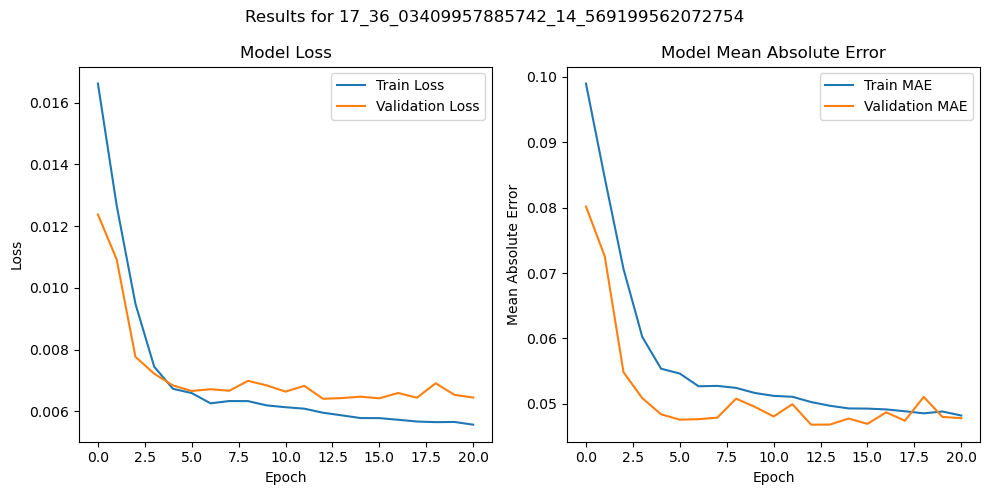

32/32 [==============================] - 30s 883ms/step

Test set Evaluation metrics for file: 17_36_03409957885742_14_569199562072754
Mean Squared Error (MSE): 0.0025938983347973425
Mean Absolute Error (MAE): 0.03550892858385861
Root Mean Squared Error (RMSE): 0.0509303282416022



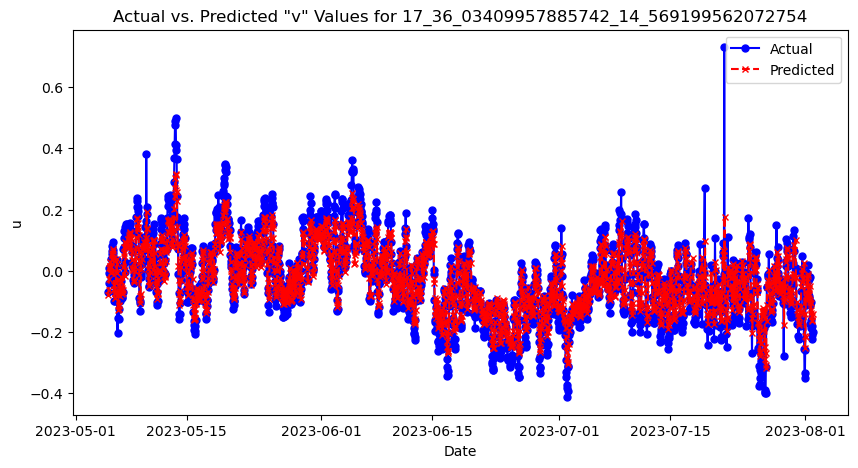

Model tarining & evaluation completed for file: 17_36_03409957885742_14_569199562072754.csv

Processing file: 18_36_056400299072266_14_447500228881836.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0929INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 304s 2s/step - loss: 0.0147 - mean_absolute_error: 0.0929 - val_loss: 0.0102 - val_mean_absolute_error: 0.0819
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0788INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 290s 2s/step - loss: 0.0109 - mean_absolute_error: 0.0788 - val_loss: 0.0073 - val_mean_absolute_error: 0.0692
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0640INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 300s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0640 - val_loss: 0.0066 - val_mean_absolute_error: 0.0668
Epoch 4/100
128/128 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0548INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 296s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0548 - val_loss: 0.0043 - val_mean_absolute_error: 0.0522
Epoch 5/100
128/128 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0507INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 299s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0507 - val_loss: 0.0036 - val_mean_absolute_error: 0.0466
Epoch 6/100
128/128 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0484INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 300s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0484 - val_loss: 0.0031 - val_mean_absolute_error: 0.0426
Epoch 7/100
128/128 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 328s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0471 - val_loss: 0.0029 - val_mean_absolute_error: 0.0409
Epoch 8/100
128/128 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 353s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0473 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369
Epoch 9/100
128/128 [==============================] - 310s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0466 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407
Epoch 10/100
128/128 [==============================] - 310s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0470 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397
Epoch 11/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0468INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 322s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0468 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365
Epoch 12/100
128/128 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0462INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 319s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0462 - val_loss: 0.0024 - val_mean_absolute_error: 0.0362
Epoch 13/100
128/128 [==============================] - 325s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366
Epoch 14/100
128/128 [==============================] - 320s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0460 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370
Epoch 15/100
128/128 [==============================] - 322s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0467 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379
Epoch 16/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0465INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 329s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0465 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 17/100
128/128 [==============================] - 314s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356
Epoch 18/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0469INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 322s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0469 - val_loss: 0.0022 - val_mean_absolute_error: 0.0345
Epoch 19/100
128/128 [==============================] - 317s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0464 - val_loss: 0.0023 - val_mean_absolute_error: 0.0349
Epoch 20/100
128/128 [==============================] - 316s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 21/100
128/128 [==============================] - 315s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0451 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359
Epoch 22/100
128/128 [==============================] - 314s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0023 - val_mean_absolute_error: 0.0351
Epoch 23/100
128/128 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0456INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 325s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0456 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 24/100
128/128 [==============================] - 309s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0024 - val_mean_absolute_error: 0.0356
Epoch 25/100
128/128 [==============================] - 309s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0451 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 26/100
128/128 [==============================] - 308s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0458 - val_loss: 0.0023 - val_mean_absolute_error: 0.0349
Epoch 27/100
128/128 [==============================] - 308s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0457 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 28/100
128/128 [==============================] - 308s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0458 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 29/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 317s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0452 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 32/100
128/128 [==============================] - 309s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0456 - val_loss: 0.0023 - val_mean_absolute_error: 0.0348
Epoch 33/100
128/128 [==============================] - 309s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 34/100
128/128 [==============================] - 309s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0446 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 35/100
128/128 [==============================] - 308s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0449 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 36/100
128/128 [==============================] - 308s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0452 - val_loss: 0.0022 - val_mean_absolute_error: 0.0344
Epoch 37/10

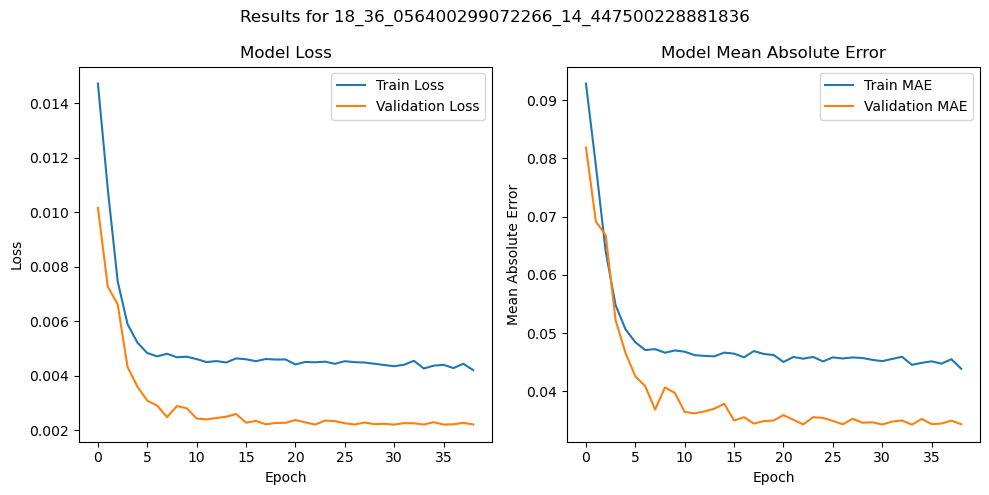

27/27 [==============================] - 27s 933ms/step

Test set Evaluation metrics for file: 18_36_056400299072266_14_447500228881836
Mean Squared Error (MSE): 0.0023254824603339136
Mean Absolute Error (MAE): 0.03488949344904864
Root Mean Squared Error (RMSE): 0.048223256426063905



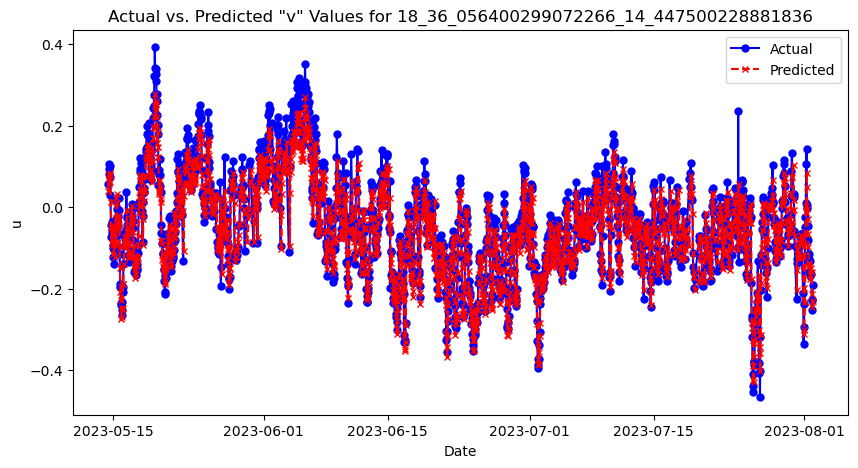

Model tarining & evaluation completed for file: 18_36_056400299072266_14_447500228881836.csv

Processing file: 19_36_056400299072266_14_48799991607666.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0955INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 345s 2s/step - loss: 0.0159 - mean_absolute_error: 0.0955 - val_loss: 0.0107 - val_mean_absolute_error: 0.0820
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0832INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 327s 2s/step - loss: 0.0122 - mean_absolute_error: 0.0832 - val_loss: 0.0099 - val_mean_absolute_error: 0.0807
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0687INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 327s 2s/step - loss: 0.0086 - mean_absolute_error: 0.0687 - val_loss: 0.0061 - val_mean_absolute_error: 0.0619
Epoch 4/100
138/138 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0573INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 324s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0573 - val_loss: 0.0045 - val_mean_absolute_error: 0.0523
Epoch 5/100
138/138 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0517INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 324s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0517 - val_loss: 0.0039 - val_mean_absolute_error: 0.0477
Epoch 6/100
138/138 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0486INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 347s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0486 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 7/100
138/138 [==============================] - 333s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0470 - val_loss: 0.0034 - val_mean_absolute_error: 0.0443
Epoch 8/100
138/138 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 339s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0464 - val_loss: 0.0032 - val_mean_absolute_error: 0.0429
Epoch 9/100
138/138 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 341s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0032 - val_mean_absolute_error: 0.0426
Epoch 10/100
138/138 [==============================] - 329s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0475 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439
Epoch 11/100
138/138 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0465INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 343s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0465 - val_loss: 0.0029 - val_mean_absolute_error: 0.0401
Epoch 12/100
138/138 [==============================] - 333s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0458 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441
Epoch 13/100
138/138 [==============================] - 330s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0456 - val_loss: 0.0033 - val_mean_absolute_error: 0.0434
Epoch 14/100
138/138 [==============================] - 330s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0460 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419
Epoch 15/100
138/138 [==============================] - 330s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0460 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 16/100
138/138 [==============================] - 330s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0460 - val_loss: 0.0034 - val_mean_absolute_error: 0.0443
Epoch 17/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 340s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0029 - val_mean_absolute_error: 0.0399
Epoch 18/100
138/138 [==============================] - 335s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0453 - val_loss: 0.0030 - val_mean_absolute_error: 0.0407
Epoch 19/100
138/138 [==============================] - 335s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0453 - val_loss: 0.0032 - val_mean_absolute_error: 0.0428
Epoch 20/100
138/138 [==============================] - 331s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0452 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421
Epoch 21/100
138/138 [==============================] - 335s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0031 - val_mean_absolute_error: 0.0415
Epoch 22/100
138/138 [==============================] - 331s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0454 - val_loss: 0.0031 - val_mean_absolute_error: 0.0420
Epoch 23/10

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 342s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0451 - val_loss: 0.0028 - val_mean_absolute_error: 0.0393
Epoch 25/100
138/138 [==============================] - 333s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0440 - val_loss: 0.0033 - val_mean_absolute_error: 0.0431
Epoch 26/100
138/138 [==============================] - 333s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0443 - val_loss: 0.0031 - val_mean_absolute_error: 0.0418
Epoch 27/100
138/138 [==============================] - 330s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0442 - val_loss: 0.0030 - val_mean_absolute_error: 0.0414
Epoch 28/100
138/138 [==============================] - 332s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0444 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411
Epoch 29/100
138/138 [==============================] - 331s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0449 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405
Epoch 30/10

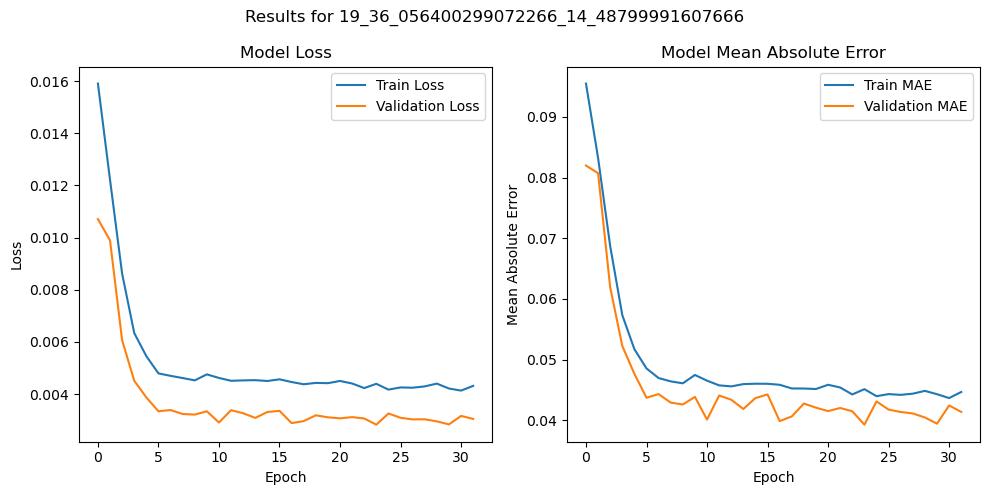

29/29 [==============================] - 28s 927ms/step

Test set Evaluation metrics for file: 19_36_056400299072266_14_48799991607666
Mean Squared Error (MSE): 0.003277830585651648
Mean Absolute Error (MAE): 0.04219906388158349
Root Mean Squared Error (RMSE): 0.05725234131152759



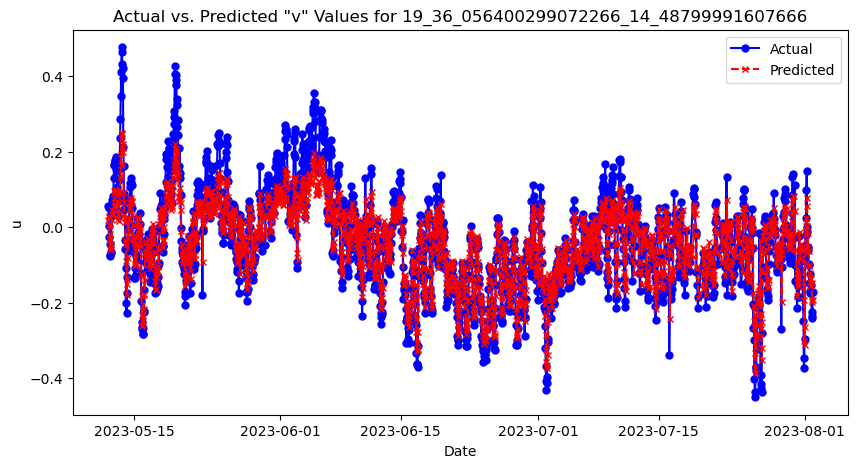

Model tarining & evaluation completed for file: 19_36_056400299072266_14_48799991607666.csv

Processing file: 20_36_056400299072266_14_528599739074707.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0936INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 382s 2s/step - loss: 0.0151 - mean_absolute_error: 0.0936 - val_loss: 0.0115 - val_mean_absolute_error: 0.0806
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0777INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 377s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0777 - val_loss: 0.0073 - val_mean_absolute_error: 0.0593
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 413s 3s/step - loss: 0.0075 - mean_absolute_error: 0.0622 - val_loss: 0.0057 - val_mean_absolute_error: 0.0485
Epoch 4/100
156/156 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0548INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 376s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0548 - val_loss: 0.0051 - val_mean_absolute_error: 0.0439
Epoch 5/100
156/156 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 372s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0509 - val_loss: 0.0050 - val_mean_absolute_error: 0.0442
Epoch 6/100
156/156 [==============================] - 357s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0505 - val_loss: 0.0051 - val_mean_absolute_error: 0.0440
Epoch 7/100
156/156 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0500INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 367s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0500 - val_loss: 0.0050 - val_mean_absolute_error: 0.0433
Epoch 8/100
156/156 [==============================] - 361s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0496 - val_loss: 0.0051 - val_mean_absolute_error: 0.0445
Epoch 9/100
156/156 [==============================] - 361s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0491 - val_loss: 0.0051 - val_mean_absolute_error: 0.0453
Epoch 10/100
156/156 [==============================] - 361s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0490 - val_loss: 0.0053 - val_mean_absolute_error: 0.0460
Epoch 11/100
156/156 [==============================] - 360s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0494 - val_loss: 0.0050 - val_mean_absolute_error: 0.0444
Epoch 12/100
156/156 [==============================] - 361s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0487 - val_loss: 0.0054 - val_mean_absolute_error: 0.0473
Epoch 13/100


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 372s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0486 - val_loss: 0.0050 - val_mean_absolute_error: 0.0443
Epoch 15/100
156/156 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0482INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 354s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0482 - val_loss: 0.0050 - val_mean_absolute_error: 0.0432
Epoch 16/100
156/156 [==============================] - 388s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0481 - val_loss: 0.0051 - val_mean_absolute_error: 0.0448
Epoch 17/100
156/156 [==============================] - 388s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0478 - val_loss: 0.0053 - val_mean_absolute_error: 0.0468
Epoch 18/100
156/156 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 393s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0478 - val_loss: 0.0049 - val_mean_absolute_error: 0.0434
Epoch 19/100
156/156 [==============================] - 405s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0475 - val_loss: 0.0049 - val_mean_absolute_error: 0.0432
Epoch 20/100
156/156 [==============================] - 405s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0474 - val_loss: 0.0050 - val_mean_absolute_error: 0.0442
Epoch 21/100
156/156 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0477INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 412s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0477 - val_loss: 0.0048 - val_mean_absolute_error: 0.0431
Epoch 22/100
156/156 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0468INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 412s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0468 - val_loss: 0.0047 - val_mean_absolute_error: 0.0425
Epoch 23/100
156/156 [==============================] - 401s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0471 - val_loss: 0.0048 - val_mean_absolute_error: 0.0437
Epoch 24/100
156/156 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0466INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 411s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0466 - val_loss: 0.0046 - val_mean_absolute_error: 0.0418
Epoch 25/100
156/156 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0463INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 409s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0463 - val_loss: 0.0046 - val_mean_absolute_error: 0.0419
Epoch 26/100
156/156 [==============================] - 382s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0463 - val_loss: 0.0048 - val_mean_absolute_error: 0.0436
Epoch 27/100
156/156 [==============================] - 381s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0461 - val_loss: 0.0047 - val_mean_absolute_error: 0.0427
Epoch 28/100
156/156 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0467INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 391s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0467 - val_loss: 0.0046 - val_mean_absolute_error: 0.0414
Epoch 29/100
156/156 [==============================] - 438s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0463 - val_loss: 0.0048 - val_mean_absolute_error: 0.0428
Epoch 30/100
156/156 [==============================] - 439s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0458 - val_loss: 0.0047 - val_mean_absolute_error: 0.0423
Epoch 31/100
156/156 [==============================] - 438s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0459 - val_loss: 0.0047 - val_mean_absolute_error: 0.0427
Epoch 32/100
156/156 [==============================] - 440s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0460 - val_loss: 0.0047 - val_mean_absolute_error: 0.0425
Epoch 33/100
156/156 [==============================] - 437s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0460 - val_loss: 0.0048 - val_mean_absolute_error: 0.0436
Epoch 34/10

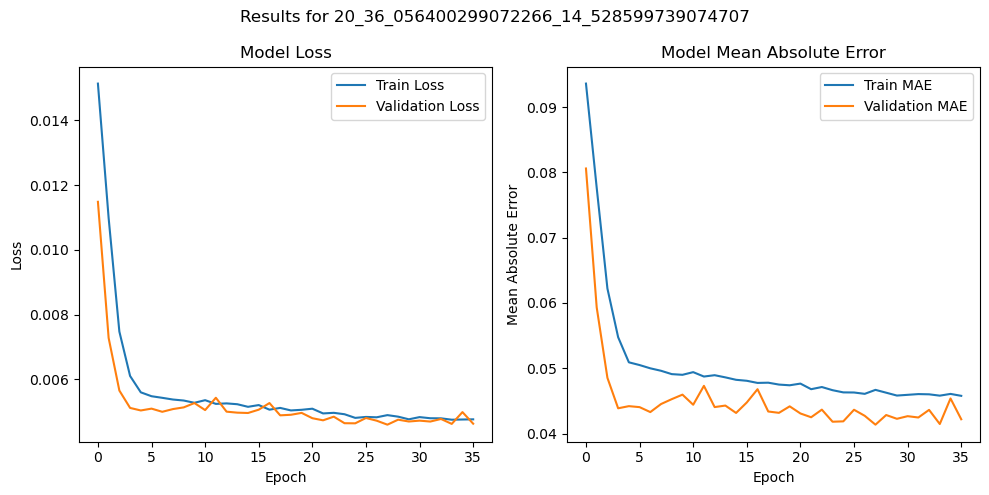

33/33 [==============================] - 39s 1s/step

Test set Evaluation metrics for file: 20_36_056400299072266_14_528599739074707
Mean Squared Error (MSE): 0.002661492163347431
Mean Absolute Error (MAE): 0.03619916583122472
Root Mean Squared Error (RMSE): 0.05158965170794848



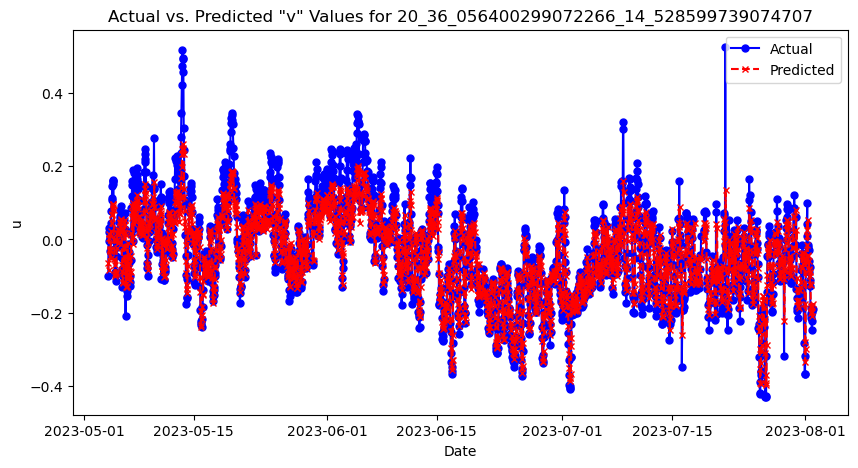

Model tarining & evaluation completed for file: 20_36_056400299072266_14_528599739074707.csv

Processing file: 21_36_056400299072266_14_569199562072754.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0942INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 437s 3s/step - loss: 0.0148 - mean_absolute_error: 0.0942 - val_loss: 0.0130 - val_mean_absolute_error: 0.0877
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0790INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 429s 3s/step - loss: 0.0108 - mean_absolute_error: 0.0790 - val_loss: 0.0060 - val_mean_absolute_error: 0.0531
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0652INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 449s 3s/step - loss: 0.0079 - mean_absolute_error: 0.0652 - val_loss: 0.0052 - val_mean_absolute_error: 0.0472
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 443s 3s/step - loss: 0.0064 - mean_absolute_error: 0.0568 - val_loss: 0.0047 - val_mean_absolute_error: 0.0440
Epoch 5/100
154/154 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0528INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 437s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0528 - val_loss: 0.0045 - val_mean_absolute_error: 0.0428
Epoch 6/100
154/154 [==============================] - 428s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0521 - val_loss: 0.0045 - val_mean_absolute_error: 0.0429
Epoch 7/100
154/154 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0518INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 439s 3s/step - loss: 0.0056 - mean_absolute_error: 0.0518 - val_loss: 0.0044 - val_mean_absolute_error: 0.0418
Epoch 8/100
154/154 [==============================] - 430s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0046 - val_mean_absolute_error: 0.0438
Epoch 9/100
154/154 [==============================] - 429s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0488 - val_loss: 0.0045 - val_mean_absolute_error: 0.0426
Epoch 10/100
154/154 [==============================] - 429s 3s/step - loss: 0.0052 - mean_absolute_error: 0.0488 - val_loss: 0.0045 - val_mean_absolute_error: 0.0421
Epoch 11/100
154/154 [==============================] - 429s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0044 - val_mean_absolute_error: 0.0423
Epoch 12/100
154/154 [==============================] - 428s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0493 - val_loss: 0.0047 - val_mean_absolute_error: 0.0447
Epoch 13/100


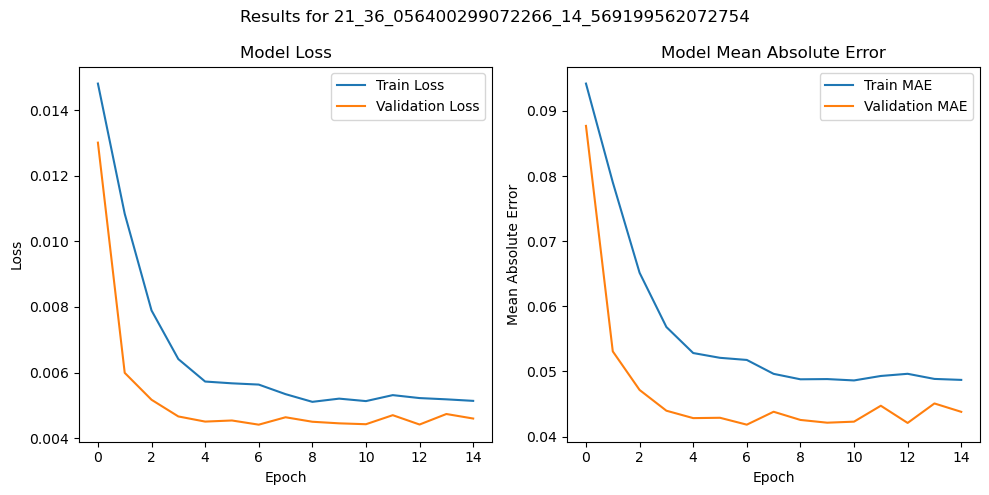

32/32 [==============================] - 37s 1s/step

Test set Evaluation metrics for file: 21_36_056400299072266_14_569199562072754
Mean Squared Error (MSE): 0.002316175522967699
Mean Absolute Error (MAE): 0.034525225828781425
Root Mean Squared Error (RMSE): 0.04812666124891377



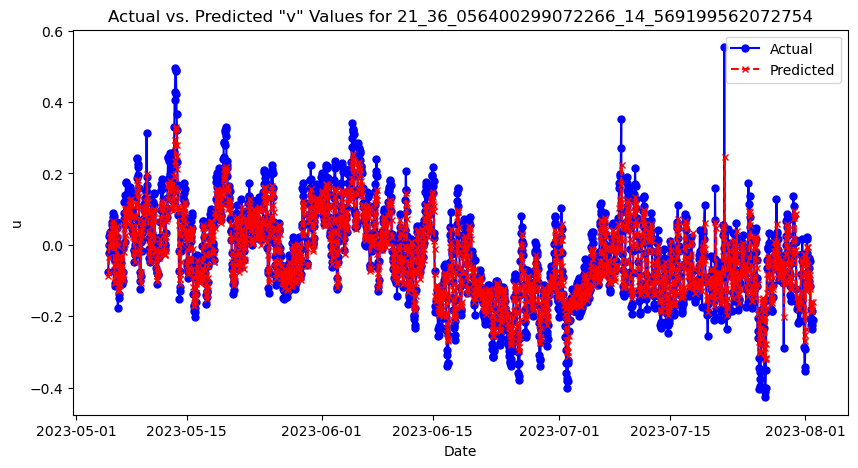

Model tarining & evaluation completed for file: 21_36_056400299072266_14_569199562072754.csv

Processing file: 22_36_07870101928711_14_366399765014648.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0709INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 304s 3s/step - loss: 0.0084 - mean_absolute_error: 0.0709 - val_loss: 0.0054 - val_mean_absolute_error: 0.0585
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0668INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 297s 3s/step - loss: 0.0075 - mean_absolute_error: 0.0668 - val_loss: 0.0045 - val_mean_absolute_error: 0.0528
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0600INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 302s 3s/step - loss: 0.0061 - mean_absolute_error: 0.0600 - val_loss: 0.0035 - val_mean_absolute_error: 0.0468
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0523INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 303s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0027 - val_mean_absolute_error: 0.0405
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0463INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 298s 3s/step - loss: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0020 - val_mean_absolute_error: 0.0339
Epoch 6/100
103/103 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0419INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 297s 3s/step - loss: 0.0032 - mean_absolute_error: 0.0419 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287
Epoch 7/100
103/103 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0395INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 296s 3s/step - loss: 0.0030 - mean_absolute_error: 0.0395 - val_loss: 0.0013 - val_mean_absolute_error: 0.0259
Epoch 8/100
103/103 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0377INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 308s 3s/step - loss: 0.0028 - mean_absolute_error: 0.0377 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 9/100
103/103 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0371INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 336s 3s/step - loss: 0.0027 - mean_absolute_error: 0.0371 - val_loss: 0.0011 - val_mean_absolute_error: 0.0231
Epoch 10/100
103/103 [==============================] - 318s 3s/step - loss: 0.0026 - mean_absolute_error: 0.0361 - val_loss: 0.0012 - val_mean_absolute_error: 0.0235
Epoch 11/100
103/103 [==============================] - 313s 3s/step - loss: 0.0026 - mean_absolute_error: 0.0359 - val_loss: 0.0012 - val_mean_absolute_error: 0.0238
Epoch 12/100
103/103 [==============================] - 318s 3s/step - loss: 0.0026 - mean_absolute_error: 0.0357 - val_loss: 0.0012 - val_mean_absolute_error: 0.0246
Epoch 13/100
103/103 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0356INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 324s 3s/step - loss: 0.0026 - mean_absolute_error: 0.0356 - val_loss: 0.0011 - val_mean_absolute_error: 0.0233
Epoch 14/100
103/103 [==============================] - 322s 3s/step - loss: 0.0025 - mean_absolute_error: 0.0352 - val_loss: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 15/100
103/103 [==============================] - 322s 3s/step - loss: 0.0025 - mean_absolute_error: 0.0352 - val_loss: 0.0012 - val_mean_absolute_error: 0.0243
Epoch 16/100
103/103 [==============================] - 322s 3s/step - loss: 0.0025 - mean_absolute_error: 0.0352 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 17/100
103/103 [==============================] - 322s 3s/step - loss: 0.0025 - mean_absolute_error: 0.0354 - val_loss: 0.0013 - val_mean_absolute_error: 0.0258
Epoch 18/100
103/103 [==============================] - 322s 3s/step - loss: 0.0025 - mean_absolute_error: 0.0354 - val_loss: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 19/10

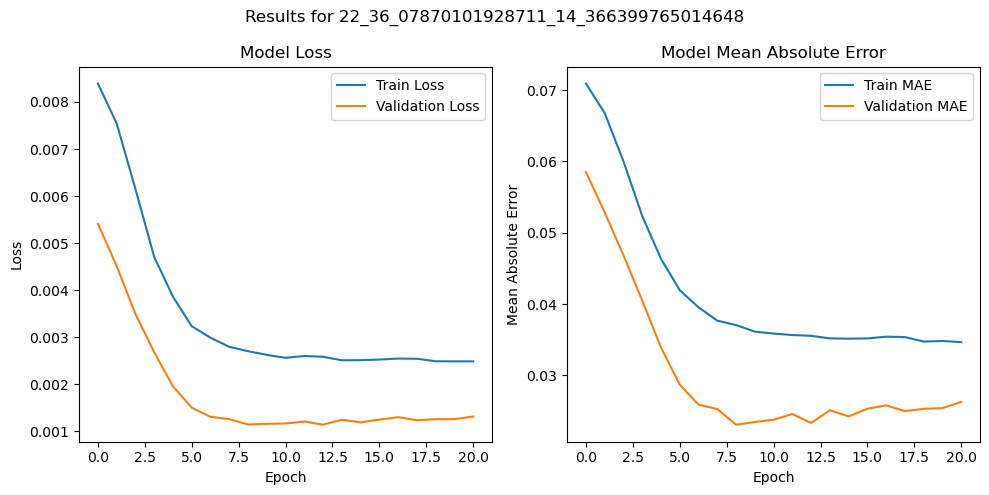

22/22 [==============================] - 27s 1s/step

Test set Evaluation metrics for file: 22_36_07870101928711_14_366399765014648
Mean Squared Error (MSE): 0.0020610638066982895
Mean Absolute Error (MAE): 0.03177336576596418
Root Mean Squared Error (RMSE): 0.045398940590043395



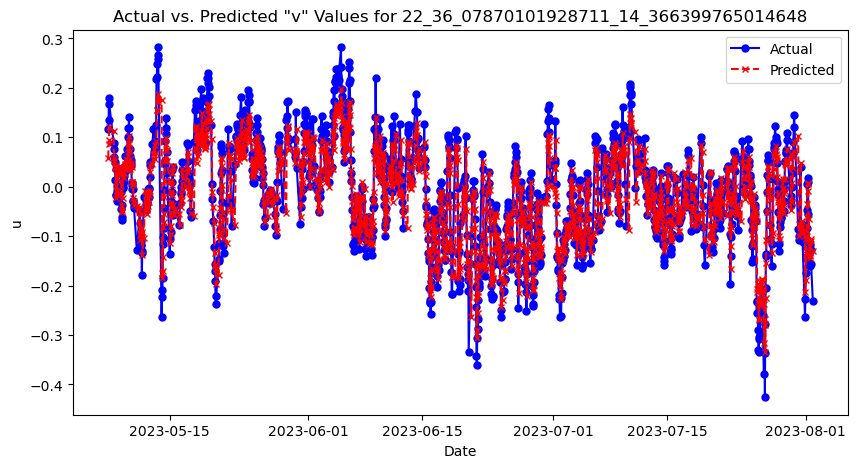

Model tarining & evaluation completed for file: 22_36_07870101928711_14_366399765014648.csv

Processing file: 23_36_07870101928711_14_406900405883789.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0842INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 405s 3s/step - loss: 0.0117 - mean_absolute_error: 0.0842 - val_loss: 0.0081 - val_mean_absolute_error: 0.0727
Epoch 2/100
125/125 [==============================] - 372s 3s/step - loss: 0.0093 - mean_absolute_error: 0.0745 - val_loss: 0.0091 - val_mean_absolute_error: 0.0797
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0649INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 385s 3s/step - loss: 0.0072 - mean_absolute_error: 0.0649 - val_loss: 0.0068 - val_mean_absolute_error: 0.0694
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0567INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 388s 3s/step - loss: 0.0056 - mean_absolute_error: 0.0567 - val_loss: 0.0043 - val_mean_absolute_error: 0.0533
Epoch 5/100
125/125 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0509INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 397s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0509 - val_loss: 0.0034 - val_mean_absolute_error: 0.0467
Epoch 6/100
125/125 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 397s 3s/step - loss: 0.0041 - mean_absolute_error: 0.0471 - val_loss: 0.0025 - val_mean_absolute_error: 0.0393
Epoch 7/100
125/125 [==============================] - 380s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391
Epoch 8/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0441INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 390s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0441 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384
Epoch 9/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0437INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 378s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0437 - val_loss: 0.0023 - val_mean_absolute_error: 0.0369
Epoch 10/100
125/125 [==============================] - 382s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0442 - val_loss: 0.0024 - val_mean_absolute_error: 0.0379
Epoch 11/100
125/125 [==============================] - 381s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0435 - val_loss: 0.0023 - val_mean_absolute_error: 0.0368
Epoch 12/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0436INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 393s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0436 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342
Epoch 13/100
125/125 [==============================] - 382s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0427 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367
Epoch 14/100
125/125 [==============================] - 380s 3s/step - loss: 0.0035 - mean_absolute_error: 0.0424 - val_loss: 0.0023 - val_mean_absolute_error: 0.0361
Epoch 15/100
125/125 [==============================] - 378s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0023 - val_mean_absolute_error: 0.0365
Epoch 16/100
125/125 [==============================] - 376s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0422 - val_loss: 0.0027 - val_mean_absolute_error: 0.0405
Epoch 17/100
125/125 [==============================] - 372s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0431 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364
Epoch 18/10

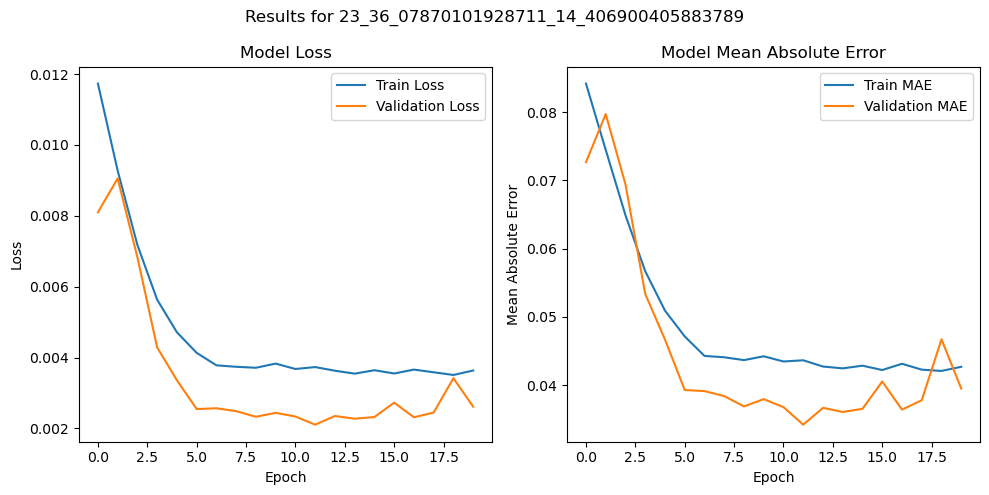

26/26 [==============================] - 35s 1s/step

Test set Evaluation metrics for file: 23_36_07870101928711_14_406900405883789
Mean Squared Error (MSE): 0.002423479122587
Mean Absolute Error (MAE): 0.035577181903034924
Root Mean Squared Error (RMSE): 0.049228844416530845



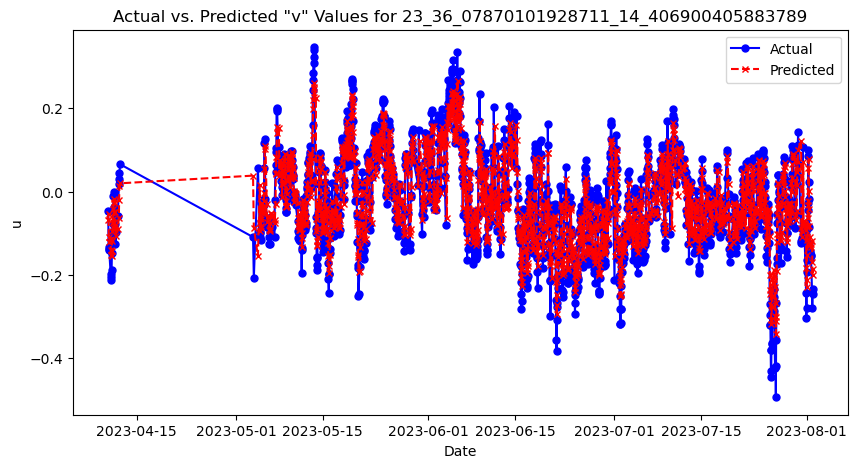

Model tarining & evaluation completed for file: 23_36_07870101928711_14_406900405883789.csv

Processing file: 24_36_07870101928711_14_447500228881836.csv



C:\Users\markd\AppData\Local\Temp\ipykernel_4592\1678116203.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0879INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 467s 3s/step - loss: 0.0135 - mean_absolute_error: 0.0879 - val_loss: 0.0094 - val_mean_absolute_error: 0.0785
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0713INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 428s 3s/step - loss: 0.0092 - mean_absolute_error: 0.0713 - val_loss: 0.0077 - val_mean_absolute_error: 0.0727
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0592INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 432s 3s/step - loss: 0.0067 - mean_absolute_error: 0.0592 - val_loss: 0.0038 - val_mean_absolute_error: 0.0492
Epoch 4/100
151/151 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0508INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 468s 3s/step - loss: 0.0052 - mean_absolute_error: 0.0508 - val_loss: 0.0032 - val_mean_absolute_error: 0.0446
Epoch 5/100
151/151 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 468s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0478 - val_loss: 0.0029 - val_mean_absolute_error: 0.0414
Epoch 6/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 455s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0461 - val_loss: 0.0027 - val_mean_absolute_error: 0.0401
Epoch 7/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0460INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 463s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0460 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393
Epoch 8/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0458INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 460s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0458 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 9/100
151/151 [==============================] - 452s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0452 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392
Epoch 10/100
151/151 [==============================] - 461s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0456 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372
Epoch 11/100
151/151 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0460INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 469s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0460 - val_loss: 0.0021 - val_mean_absolute_error: 0.0340
Epoch 12/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0458INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 459s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0458 - val_loss: 0.0021 - val_mean_absolute_error: 0.0337
Epoch 13/100
151/151 [==============================] - 487s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0454 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338
Epoch 14/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0449INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 460s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0449 - val_loss: 0.0021 - val_mean_absolute_error: 0.0335
Epoch 15/100
151/151 [==============================] - 437s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 16/100
151/151 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0459INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 452s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0459 - val_loss: 0.0021 - val_mean_absolute_error: 0.0332
Epoch 17/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0448INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 449s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0448 - val_loss: 0.0020 - val_mean_absolute_error: 0.0325
Epoch 18/100
151/151 [==============================] - 442s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0448 - val_loss: 0.0021 - val_mean_absolute_error: 0.0336
Epoch 19/100
151/151 [==============================] - 436s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0445 - val_loss: 0.0020 - val_mean_absolute_error: 0.0326
Epoch 20/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0452INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 453s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0452 - val_loss: 0.0020 - val_mean_absolute_error: 0.0321
Epoch 21/100
151/151 [==============================] - 511s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0445 - val_loss: 0.0022 - val_mean_absolute_error: 0.0346
Epoch 22/100
151/151 [==============================] - 788s 5s/step - loss: 0.0041 - mean_absolute_error: 0.0441 - val_loss: 0.0021 - val_mean_absolute_error: 0.0336
Epoch 23/100
151/151 [==============================] - 739s 5s/step - loss: 0.0043 - mean_absolute_error: 0.0448 - val_loss: 0.0022 - val_mean_absolute_error: 0.0342
Epoch 24/100
151/151 [==============================] - 807s 5s/step - loss: 0.0043 - mean_absolute_error: 0.0453 - val_loss: 0.0022 - val_mean_absolute_error: 0.0345
Epoch 25/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0448INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_

INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 702s 5s/step - loss: 0.0043 - mean_absolute_error: 0.0448 - val_loss: 0.0020 - val_mean_absolute_error: 0.0323
Epoch 26/100
151/151 [==============================] - 495s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0439 - val_loss: 0.0020 - val_mean_absolute_error: 0.0330
Epoch 27/100
151/151 [==============================] - 435s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0442 - val_loss: 0.0021 - val_mean_absolute_error: 0.0336
Epoch 28/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0454INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 421s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0454 - val_loss: 0.0019 - val_mean_absolute_error: 0.0317
Epoch 29/100
151/151 [==============================] - 414s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0439 - val_loss: 0.0020 - val_mean_absolute_error: 0.0320
Epoch 30/100
151/151 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0445INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/LSTM/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 468s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0445 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 31/100
151/151 [==============================] - 461s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0441 - val_loss: 0.0019 - val_mean_absolute_error: 0.0320
Epoch 32/100
151/151 [==============================] - 482s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0444 - val_loss: 0.0019 - val_mean_absolute_error: 0.0318
Epoch 33/100
151/151 [==============================] - 431s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0444 - val_loss: 0.0020 - val_mean_absolute_error: 0.0322
Epoch 34/100
 95/151 [=================>............] - ETA: 3:17 - loss: 0.0044 - mean_absolute_error: 0.0454

In [10]:
# Directory for saving models 
model_save_directory = "Data/saved_models/LSTM/models_v"
os.makedirs(model_save_directory, exist_ok=True)

# Function to extract the numerical index from the filename
def extract_index(filename):
    # Index is always before the first underscore
    index_part = filename.split("_")[0]
    try:
        return int(index_part)
    except ValueError:
        # In case of any error, return a large number to sort this file at the end
        return float('inf')

# List all CSV files in the directory and sort them numerically based on the index
csv_files = sorted([f for f in os.listdir(save_directory) if f.endswith('.csv')], key=extract_index)

print(csv_files,"\n")
print("="*175)

# Set up early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min', 
                               restore_best_weights=True)

# Loop through each CSV file in the directory
for file in csv_files:
    print("="*175)
    print(f"Processing file: {file}\n")

    # Load the dataset from the CSV file
    df = pd.read_csv(os.path.join(save_directory, file))

    # Convert the 'time' column to datetime object and set it as the index 
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    df.set_index('time', inplace=True)

    # Select 'u' and 'v' columns as input features 
    df_input = df[['u', 'v']]
    features = df_input.to_numpy()

    # Set the 'v' column as the target variable 
    target = df_input['v'].values

    # Splitting Data into Train, Validation, and Test sets (70-15-15 split)
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

    # Time series generator parameters
    win_length = 72 # 3 Days
    batch_size = 64 # 64 samples per batch
    num_features = 2 # 'u' and 'v' columns

    # Creating the time series generators for the training, validation, and test sets
    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    # Building the LSTM Model Architecture
    model = Sequential([
        LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile the model 
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # Define ModelCheckpoint callback to save the best model during training
    model_checkpoint = ModelCheckpoint(filepath=f"{model_save_directory}/{file[:-4]}",
                                       save_best_only=True, 
                                       monitor='val_loss', 
                                       mode='min', 
                                       save_format='tf',
                                       verbose=0)

    # Fit the model to the training data
    history = model.fit(train_generator, epochs=100, validation_data=val_generator, shuffle=False, callbacks=[early_stopping, model_checkpoint])

    # Determine the epoch number at best performance
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience

    # Print the best epoch number and the best validation loss achieved
    print("="*175)
    print(f"Training stopped at epoch: {best_epoch + 1}")
    print(f"Best validation loss achieved at epoch: {best_epoch + 1}\n")

    # Plot training and validation loss values 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training and validation mean absolute error values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Display the plots 
    plt.suptitle(f'Results for {file[:-4]}')
    plt.tight_layout()
    plt.show()

    # Generate predictions for the test data 
    predictions = model.predict(test_generator)
    test_indexes = df.index[-len(predictions):]

    # Prepare the final DataFrame for plotting and analysis
    df_final = pd.DataFrame(df.loc[test_indexes])
    df_final['v_pred'] = predictions.flatten() 

    # Calculate evaluation metrics
    mse = mean_squared_error(df_final['v'], df_final['v_pred'])  
    mae = mean_absolute_error(df_final['v'], df_final['v_pred']) 
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print(f'\nTest set Evaluation metrics for file: {file[:-4]}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}\n')

    # Plot Actual vs. Predicted 'u' Values
    plt.figure(figsize=(10, 5))
    plt.plot(df_final.index, df_final['v'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
    plt.plot(df_final.index, df_final['v_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
    plt.title(f'Actual vs. Predicted "v" Values for {file[:-4]}')  
    plt.xlabel('Date') 
    plt.ylabel('u')
    plt.legend()
    plt.show()
    
    print("="*175)
    print(f"Model tarining & evaluation completed for file: {file}")
    print("="*175, "\n")

## Making Real-life Predictions from Data (Simulation)
This section outlines the process of making predictions based on real-life data collected over a span of three days. The goal is to use data from the previous three days to simulate a prediction of the sea surface currents for the 4th of August, demonstrating the application in real-world scenarios.

### Extract 3 Days of Inputs for Each Coordinate Pair

- **Data Loading**: Retrieve sea surface current data from August 1, 2023, to August 3, 2023, and load it.
- **Dataframe Conversion**: Transform the loaded NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **Data Organization**: Set up a directory specifically for storing the processed data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Ensure the data is in order to maintain the sequence integrity.
    - Apply cubic spline interpolation to fill in any missing 'u' and 'v' values, ensuring a continuous dataset.
- **File Saving**: Format latitude and longitude information for compatibility with filenames and save the individual data frames as seperate CSV files. Each file is uniquely named to correspond with its geographic location.

In [ ]:
# Load the dataset (from August 1, 2023 till August 3, 2023) 
input_netcdf_path = "Data/model_IO/3_day_input_SSC_Data.nc"
dataset = xr.open_dataset(input_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files 
input_data_directory = "Data/3_day_input_data_frames"
os.makedirs(input_data_directory, exist_ok=True)

# Loop through each pair of coordinates 
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    df_specific = df[(df['lat'] == lat) & (df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time 
    df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them in using the nearest value
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_3_day.csv"
    filepath = os.path.join(input_data_directory, filename)
    df_specific.to_csv(filepath, index=False)
    print(f"Saved 3-day data for (lat: {lat}, lon: {lon}) as {filename}")
    
print("="*175)

### Extract 1 day of actaul data for each coordinate pair to use for comparison 

- **Data Loading**: Access actual sea surface current data for August 4th, 2023, to compare against the predictions.
- **Dataframe Conversion**: Transform the NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **File Organization**: Establish a directory specifically for storing actual data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Sort this data to maintain the correct time sequence.
    - Fill in missing 'u' and 'v' data points using cubic spline interpolation.
- **File Saving**: Adjust latitude and longitude information for filename compatibility and save the processed data frames as seperate CSV files. Each file is distinctly named according to its geographic location.

In [ ]:
# Load the dataset for the next day (August 4th, 2023) 
actual_netcdf_path = "Data/model_IO/1_day_actual_4th_SSC_Data.nc"
actual_dataset = xr.open_dataset(actual_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset index
actual_df = actual_dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
actual_data_directory = "Data/1_day_actual_data_frames"
os.makedirs(actual_data_directory, exist_ok=True)

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    actual_df_specific = actual_df[(actual_df['lat'] == lat) & (actual_df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time
    actual_df_specific.sort_values('time', inplace=True)

    # Check if there are enough non-NaN values to apply cubic spline
    if actual_df_specific[['u', 'v']].count().min() >= 4:
        # Enough data points, use cubic spline
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='spline', order=3)
    else:
        # Not enough data points, use linear interpolation
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='linear')

    # Fill remaining NaNs at the beginning or end
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')
    
    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_1_day.csv"
    filepath = os.path.join(actual_data_directory, filename)
    actual_df_specific.to_csv(filepath, index=False)
    print(f"Saved 1-day actual data for (lat: {lat}, lon: {lon}) as {filename}")

print("="*175)

### Rolling Prediction for 24 hours

This section performs a series of rolling predictions, for a total of 24 hours, utilizing the previously trained models. 

- **Prediction Initialization**: Begin with an empty list to store outcomes from all models.
- **Prediction Span**: Set the forecast length to 24 hours (1 day).
- **Model Access**: Locate all saved LSTM models from the designated storage directory.
- **Iterative Forecasting**: For each saved model:
    - Retrieve the model's unique identifier.
    - Load the LSTM model.
    - Prepare input data derived from the preceding three days corresponding to each geographical location.
    - Execute sequential predictions where each hourly prediction informs the next, mirroring real-world forecasting scenarios. Specifically:
        - Utilize the model to forecast the next 'u' value based on the last 72 hours (3 days) of data.
        - Update the input feature set for the subsequent prediction by appending the newly predicted 'u' value while shifting the dataset forward by one hour, ensuring the model consistently receives fresh data reflecting the most recent conditions.
        - Importantly, while 'u' values are iteratively forecasted and updated, the 'v' values are directly drawn from the actual data for the corresponding hour, maintaining the model's contextual relevance to evolving environmental conditions.
- **Data Synchronization**: Align each prediction with actual data to evaluate the model's performance accurately.
    - Preprocess real data to match the model's input structure.
    - Record every hourly forecast alongside actual measurements for comparison.
- **Performance Metrics**: For each model, compute and report key metrics:
    - **MAE (Mean Absolute Error)**: Reflects the average magnitude of errors between predicted and actual values, irrespective of direction.
    - **MSE (Mean Squared Error)**: Emphasizes larger errors by squaring them, thus penalizing more significant discrepancies more severely.
    - **RMSE (Root Mean Squared Error)**: Provides error magnitude in the same units as the predicted values.
- **Result Compilation**: Aggregate all hourly predictions across all models and locations into a single DataFrame, creating a comprehensive overview of the forecasting performance.
- **Save Predictions**: Store the combined predictions as a CSV file.

In [ ]:
# Initialize a list to collect the results of all predictions
all_predictions = []

# Number of hours to predict into the future
n_future_hours = 24  

# Specify the directory where saved models are stored
model_directory = "Data/saved_models/LSTM/models_v"

# Retrieve and sort paths for all saved models within the specified directory based on the numerical index
model_paths = sorted(
    [os.path.join(model_directory, filename).replace("\\", "/") for filename in os.listdir(model_directory)],
    key=lambda x: extract_index(os.path.basename(x).split('.')[0])
)

# Iterate over each model to perform predictions
for model_path in model_paths:
    # Extract model identifier from the file name
    model_id = os.path.basename(model_path).split('.')[0]  
    
    print("="*175)
    print(f"Processing model: {model_id}")
    print("="*175, "\n")

    # Load the saved model from its path
    model = load_model(model_path)

    # Define paths for input data and actual comparison data
    input_data_path = os.path.join(input_data_directory, f"{model_id}_3_day.csv").replace("\\", "/")
    actual_data_path = os.path.join(actual_data_directory, f"{model_id}_1_day.csv").replace("\\", "/")

    # Load and preprocess input data from CSV file
    input_data_df = pd.read_csv(input_data_path)
    input_data_df['time'] = pd.to_datetime(input_data_df['time'])
    features = input_data_df[['u', 'v']].values[-win_length:].reshape(1, win_length, num_features)

    # Initialize a list to store predictions for each hour
    predictions_v = []  
    # Perform rolling predictions for the defined number of future hours
    for i in range(n_future_hours):
        # Predict the next 'v' value using the model
        current_prediction_v = model.predict(features, verbose=0)[0, 0]
        # Append the prediction to the list
        predictions_v.append(current_prediction_v)
        # Update the features for the next prediction step
        next_u_values = np.roll(features[0, :, 0], -1)
        # Update features array with new predictions and actual 'u' values
        features = np.column_stack((next_u_values, np.roll(features[0, :, 1], -1))).reshape(1, win_length, num_features)
        features[0, -1, 1] = current_prediction_v  

    # Load and preprocess actual data for comparison
    actual_data_df = pd.read_csv(actual_data_path)
    actual_data_df['time'] = pd.to_datetime(actual_data_df['time'])
    actual_v_values = actual_data_df['v'].values[:n_future_hours]  
    # Use the first row's lat and lon for location
    lat, lon = actual_data_df[['lat', 'lon']].values[0]  

    # Compile all predictions with their corresponding timestamps and locations
    for i, predicted_v in enumerate(predictions_v):  
        all_predictions.append([actual_data_df['time'].iloc[i], lat, lon, predicted_v])  

    # Calculate evaluation metrics 
    mae = mean_absolute_error(actual_v_values, predictions_v) 
    mse = mean_squared_error(actual_v_values, predictions_v)  
    rmse = np.sqrt(mse)

    # Display calculated metrics
    print(f"Metrics for model {model_id}:\nMAE = {mae}\nMSE = {mse}\nRMSE = {rmse}\n")

print("="*175)

# Convert the list of all predictions into a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=['time', 'lat', 'lon', 'v'])

# Save the compiled predictions to a CSV file
predictions_df.to_csv("Data/model_IO/LSTM/LSTM_merged_predictions_v.csv", index=False)
print("Saved merged predictions to 'Data/model_IO/LSTM/LSTM_merged_predictions_v.csv'")
print("="*175)

---